 ***Spatial analysis of natural scenes notebook***
 
This notebook is created to generate plots for the spatial analysis paper from the `SCENES` dataset.

In [1]:
import os
import re
import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cmcrameri import cm     #Scientific color maps
from matplotlib.pyplot import figure
from matplotlib import gridspec
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import seaborn as sns
import csv  
import colour
import scipy.stats as stats
from scipy.stats import gaussian_kde
from scipy.stats import linregress

In [2]:
# Display data frames in scrolling format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Set default font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 10

In [4]:
# Color palettes

# Choose the sequential color palette from cmcrameri
cmap = cm.batlow
cmap_seq = cm.oslo.reversed()
cmap_blues = plt.colormaps["Blues"] 

# Define the custom color palette
photoreceptor_colors = {
    'L cones': (0.8941, 0.1020, 0.1098),
    'M cones': (0.3020, 0.6863, 0.2902),
    'S cones': (0.2157, 0.4941, 0.7216),
    'Rods': (0.0157, 0.4118, 0.3333),
    'Melanopsin': (0.1255, 0.6549, 0.7686)   
}

In [5]:
# Call another Jupyter notebook "scenes_dataset_functions" that contains all required functions
%run scenes_dataset_functions.ipynb             

Current working directory: C:\Users\ntabandeh\projects\SCENES_analysis
New working directory: \\kfs\tscn-dropbox\scenes\data


# Preprocessing

## directory paths

In [6]:
# Show the code directory path
cwd = os.getcwd()
print('Current working directory:', cwd)

Current working directory: \\kfs\tscn-dropbox\scenes\data


In [7]:
# working directory path
root_dir = r'\\kfs\tscn-dropbox\scenes\data'

wp_derivatives_dir = f'{root_dir}\\derivatives\wp_derivatives'

# The spatial analysis directory path
spatial_paper_dir = f'{root_dir}\\results\spatial-paper'

## Merged metadata, Jeti and WestBoro metrics

In [296]:
# Read the dataframe from the csv file (merged_wp_jeti_metadata_df.csv)

merged_wp_jeti_metadata_df = pd.read_csv(
    f'{spatial_paper_dir}\\merged_wp_jeti_metadata_df.csv',
    header=0,
    index_col=0)
merged_wp_jeti_metadata_df.head()

timestamp  invalid_pixels_L cones  overexposed_pixels_L cones  \
record                                                                      
1       20230208T0800                    2712                      154712   
2       20230208T0900                    2712                     2658410   
3       20230208T0930                    2712                     2820669   
4       20230208T1000                    2712                     2294105   
5       20230208T1030                    2712                     1871378   

        average_radiances_L cones  invalid_pixels_M cones  \
record                                                      
1                          4.6948                       0   
2                          7.6841                       0   
3                          7.2499                       0   
4                          7.4355                       0   
5                          7.5897                       0   

        overexposed_pixels_M cones  average_radiances_M cones  \
record                                                          
1                            46366                     3.8895   
2                           238240                    11.7963   
3                           345475                    12.4157   
4                           108568                    11.7486   
5                            17760                    11.0070   

        invalid_pixels_S cones  overexposed_pixels_S cones  \
record                                                       
1                         6776                        4539   
2                         6776                       74539   
3                         6776                       90147   
4                         6776                       19786   
5                         6776                          41   

        average_radiances_S cones  invalid_pixels_Rods  \
record                                                   
1                          1.3800                 6099   
2                          6.1592                 6099   
3                          7.1380                 6099   
4                          6.8834                 6099   
5                          6.5185                 6099   

        overexposed_pixels_Rods  average_radiances_Rods  \
record                                                    
1                         79216                  3.4245   
2                       2996906                  5.5191   
3                       3272459                  5.2400   
4                       2920873                  5.4247   
5                       2638311                  5.6039   

        invalid_pixels_Melanopsin  overexposed_pixels_Melanopsin  \
record                                                             
1                           12873                          26928   
2                           12873                         983138   
3                           12873                        1536965   
4                           12873                        1038990   
5                           12873                         700578   

        average_radiances_Melanopsin  average_luminance_L cones  \
record                                                            
1                             3.0511                   2.882177   
2                             8.6612                   4.717333   
3                             8.2636                   4.450774   
4                             8.7081                   4.564715   
5                             8.7907                   4.659380   

        average_luminance_M cones  average_luminance_S cones  \
record                                                         
1                        2.671679                   1.040557   
2                        8.102821                   4.644200   
3                        8.528284                   5.382242   
4                        8.070056                   5.190266   
5

In [9]:
merged_wp_jeti_metadata_df.shape[0]

671

In [11]:
locations = merged_wp_jeti_metadata_df["location"].unique()
locations

array(['Tübingen (Germany)', 'Ottawa (Canada)', 'Munich (Germany)',
       'Prague (Czech Republic)', 'Lyon (France)'], dtype=object)

In [12]:
views = merged_wp_jeti_metadata_df["view"].unique()
views

array(['Outdoor view', 'Indoor w/ window view', 'Indoor w/o window view'], dtype=object)

In [13]:
# Get unique values in 'view' and their counts
view_counts = merged_wp_jeti_metadata_df['view'].value_counts()

# Print the unique values and their counts
print(f'Views and counts:\n{view_counts}')

Views and counts:
view
Outdoor view              362
Indoor w/ window view     194
Indoor w/o window view    115
Name: count, dtype: int64


In [208]:
# Create a color mapping for 'view' using the cmap to ensure consistent colors

# Define the color palette
cmap_colors = [cmap(i / len(views)) for i in range(len(views))]

# Map the colors to the views in the specified order
view_color_mapping = dict(zip(['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view'], cmap_colors))


In [21]:
# WP central stats

# Select columns that end with 'Mean' or start with 'rms'
selected_columns = [
    col for col in merged_wp_jeti_metadata_df.columns
    if col.startswith('average') or col.startswith('rms')
]

# Calculate overall statistics (mean, min, max, std) for these selected columns
overall_stats = merged_wp_jeti_metadata_df[selected_columns].agg(
    ['mean','std', 'median', 'min', 'max']).transpose()

# Calculate IQR (Interquartile Range)
overall_stats['IQR'] = (
    merged_wp_jeti_metadata_df[selected_columns].quantile(0.75) -
    merged_wp_jeti_metadata_df[selected_columns].quantile(0.25)
)

overall_stats.columns = [
    'overall_mean', 'overall_std', 'overall_median', 'overall_min', 'overall_max', 'overall_IQR'
]

overall_stats.reset_index(inplace=True)

# Calculate statistics (mean, max, std) by 'view' category for these selected columns
view_stats = merged_wp_jeti_metadata_df.groupby('view')[selected_columns].agg(
    ['mean','std', 'median', 'min', 'max'])

# Calculate IQR (Interquartile Range) by 'view'
IQR = (
    merged_wp_jeti_metadata_df.groupby('view')[selected_columns].quantile(0.75) -
    merged_wp_jeti_metadata_df.groupby('view')[selected_columns].quantile(0.25)
)
IQR.columns = pd.MultiIndex.from_product([IQR.columns, ['IQR']])

view_stats = pd.concat([view_stats, IQR], axis=1)
view_stats.reset_index(inplace=True)
# Reset index and flatten the multi-level columns for view stats
view_stats.columns = ['_'.join(col).strip() for col in view_stats.columns]



# Transpose the DataFrame to have 'view' as columns and metrics as rows
view_stats.rename(columns={'view_': 'view'}, inplace=True)

# Rearranging the columns to have the desired order
new_columns = []
for col in selected_columns:
    new_columns.extend([f"{col}_mean", f"{col}_std", f"{col}_median", f"{col}_min", f"{col}_max", f"{col}_IQR"])

# Ensure to include the 'view' column at the front
new_columns = ['view'] + new_columns

# Reindex view_stats DataFrame to have columns in the new order
view_stats = view_stats[new_columns]

view_stats = view_stats.round(4)

# Save the Overal stats as a csv
overall_stats.to_csv(f'{spatial_paper_dir}\\wp_statistics_overall.csv', sep=',', index=False)

In [18]:
overall_stats

index  overall_mean  overall_std  overall_median  \
0      average_radiances_L cones      1.892643     2.367183        0.765800   
1      average_radiances_M cones      1.923062     2.775012        0.681600   
2      average_radiances_S cones      1.049948     1.628125        0.314000   
3         average_radiances_Rods      1.553982     1.953138        0.629200   
4   average_radiances_Melanopsin      1.604801     2.261871        0.561400   
5      average_luminance_L cones      1.161909     1.453233        0.470131   
6      average_luminance_M cones      1.320942     1.906142        0.468188   
7      average_luminance_S cones      0.791688     1.227650        0.236764   
8         average_luminance_Rods      1.071931     1.347267        0.434020   
9   average_luminance_Melanopsin      1.963564     2.767527        0.686905   
10          rms_contrast_L cones      0.139534     0.078832        0.130400   
11          rms_contrast_M cones      0.125720     0.078327        0.111300   
12          rms_contrast_S cones      0.136270     0.083977        0.126900   
13             rms_contrast_Rods      0.150573     0.084413        0.136800   
14       rms_contrast_Melanopsin      0.142995     0.084716        0.128700   

    overall_min  overall_max  overall_IQR  
0      0.000400    10.946200     2.569100  
1      0.000600    15.746400     2.345200  
2      0.000100    10.247800     1.132150  
3      0.000200     8.473000     2.042000  
4      0.000200    10.976400     1.955800  
5      0.000246     6.719963     1.577192  
6      0.000412    10.816126     1.610907  
7      0.000075     7.727113     0.853671  
8      0.000138     5.844643     1.408564  
9      0.000245    13.430245     2.393032  
10     0.001000     0.380800     0.114800  
11     0.000800     0.372400     0.113400  
12     0.000800     0.388000     0.114850  
13     0.001200     0.389100     0.123950  
14     0.001200     0.389000     0.122700

In [19]:
view_stats

view  average_radiances_L cones_mean  \
0   Indoor w/ window view                          1.0201   
1  Indoor w/o window view                          0.1687   
2            Outdoor view                          2.9079   

   average_radiances_L cones_std  average_radiances_L cones_median  \
0                         1.5954                            0.3768   
1                         0.2287                            0.1008   
2                         2.5755                            2.1204   

   average_radiances_L cones_min  average_radiances_L cones_max  \
0                         0.0083                         6.8467   
1                         0.0074                         1.7264   
2                         0.0004                        10.9462   

   average_radiances_L cones_IQR  average_radiances_M cones_mean  \
0                         0.6834                          0.9750   
1                         0.1654                          0.1394   
2                         3.7780                          2.9978   

   average_radiances_M cones_std  average_radiances_M cones_median  \
0                         1.6437                            0.3334   
1                         0.1670                            0.0783   
2                         3.1913                            1.7768   

   average_radiances_M cones_min  average_radiances_M cones_max  \
0                         0.0068                         8.2033   
1                         0.0070                         0.8279   
2                         0.0006                        15.7464   

   average_radiances_M cones_IQR  average_radiances_S cones_mean  \
0                         0.6957                          0.4998   
1                         0.1211                          0.0509   
2                         3.7445                          1.6622   

   average_radiances_S cones_std  average_radiances_S cones_median  \
0                         0.8728                            0.1526   
1                         0.0657                            0.0209   
2                         1.9117                            0.8262   

   average_radiances_S cones_min  average_radiances_S cones_max  \
0                         0.0021                         4.3358   
1                         0.0025                         0.2937   
2                         0.0001                        10.2478   

   average_radiances_S cones_IQR  average_radiances_Rods_mean  \
0                         0.3385                       0.8612   
1                         0.0546                       0.1251   
2                         2.2489                       2.3792   

   average_radiances_Rods_std  average_radiances_Rods_median  \
0                      1.3388                         0.3143   
1                      0.2116                         0.0573   
2                      2.1252                         1.6200   

   average_radiances_Rods_min  average_radiances_Rods_max  \
0                      0.0048                      5.5223   
1                      0.0061                      1.8512   
2                      0.0002                      8.4730   

   average_radiances_Rods_IQR  average_radiances_Melanopsin_mean  \
0                      0.6050                             0.8395   
1                      0.1128                             0.1070   
2                      3.2448                             2.4908   

   average_radiances_Melanopsin_std  average_radiances_Melanopsin_median  \
0                            1.4113                               0.2867   
1                            0.1890                               0.0456   
2                            2.5695                               1.4308   

   average_radiances_Melanopsin_min  average_radiances_Melanopsin_max  \
0                            0.0036                            6.4896   
1                            0.0050                            1.6655   
2                   

In [20]:
# Define selected columns based on column names starting with 'average' or 'rms'

selected_columns = [
    col for col in merged_wp_jeti_metadata_df.columns
    if col.startswith('average') or col.startswith('rms')
]

# Calculate basic statistics (mean, std, median, min, max) by 'view' category for these selected columns
view_stats_table = merged_wp_jeti_metadata_df.groupby('view')[selected_columns].agg(
    ['mean', 'std', 'median', 'min', 'max']
)

# Calculate IQR (Interquartile Range) by 'view'
IQR = (
    merged_wp_jeti_metadata_df.groupby('view')[selected_columns].quantile(0.75) -
    merged_wp_jeti_metadata_df.groupby('view')[selected_columns].quantile(0.25)
)
# Rename the columns in IQR to match the multi-index format
IQR.columns = pd.MultiIndex.from_product([IQR.columns, ['IQR']])

view_stats_table = pd.concat([view_stats_table, IQR], axis=1)

# Reset the column levels so that 'view' categories are top-level headers, and stats are subheaders
view_stats_table = view_stats_table.stack(level=0, future_stack=True).unstack(level=0)

# Now adjust columns to have MultiIndex with view categories at the top-level, stats as sub-level
view_stats_table.columns = pd.MultiIndex.from_product(
    [view_stats_table.columns.levels[1], ['mean', 'std', 'median', 'min', 'max', 'IQR']],
    names=['View', 'Statistic']
)

# Reset index so 'selected_columns' become the row index with "Metric" as the label
view_stats_table = view_stats_table.reset_index().rename(columns={'level_0': 'Metric'})

# Optional: rounding the data to 4 decimal places for clarity
view_stats_table = view_stats_table.round(4)

# Save the DataFrame to a CSV file
view_stats_table.to_csv(f'{spatial_paper_dir}\\wp_statistics_per_view.csv', sep=',', index=False)

In [22]:
view_stats_table


View                              index Indoor w/ window view                  \
Statistic                                                mean     std  median   
0             average_radiances_L cones                1.0201  0.1687  2.9079   
1             average_radiances_M cones                0.9750  0.1394  2.9978   
2             average_radiances_S cones                0.4998  0.0509  1.6622   
3                average_radiances_Rods                0.8612  0.1251  2.3792   
4          average_radiances_Melanopsin                0.8395  0.1070  2.4908   
5             average_luminance_L cones                0.6263  0.1036  1.7852   
6             average_luminance_M cones                0.6697  0.0958  2.0591   
7             average_luminance_S cones                0.3769  0.0384  1.2533   
8                average_luminance_Rods                0.5940  0.0863  1.6412   
9          average_luminance_Melanopsin                1.0271  0.1309  3.0476   
10                 rms_contrast_L cones                0.1294  0.0960  0.1588   
11                 rms_contrast_M cones                0.1196  0.0902  0.1403   
12                 rms_contrast_S cones                0.1302  0.0871  0.1551   
13                    rms_contrast_Rods                0.1378  0.0939  0.1754   
14              rms_contrast_Melanopsin                0.1333  0.0919  0.1644   

View                              Indoor w/o window view                  \
Statistic     min     max     IQR                   mean     std  median   
0          1.5954  0.2287  2.5755                 0.3768  0.1008  2.1204   
1          1.6437  0.1670  3.1913                 0.3334  0.0783  1.7768   
2          0.8728  0.0657  1.9117                 0.1526  0.0209  0.8262   
3          1.3388  0.2116  2.1252                 0.3143  0.0573  1.6200   
4          1.4113  0.1890  2.5695                 0.2867  0.0456  1.4308   
5          0.9794  0.1404  1.5811                 0.2313  0.0619  1.3017   
6          1.1290  0.1147  2.1921                 0.2290  0.0538  1.2205   
7          0.6581  0.0495  1.4415                 0.1150  0.0158  0.6229   
8          0.9235  0.1460  1.4659                 0.2168  0.0395  1.1175   
9          1.7268  0.2313  3.1440                 0.3508  0.0558  1.7507   
10         0.0753  0.0611  0.0793                 0.1224  0.0807  0.1488   
11         0.0724  0.0591  0.0827                 0.1152  0.0811  0.1312   
12         0.0800  0.0534  0.0873                 0.1221  0.0773  0.1482   
13         0.0824  0.0600  0.0820                 0.1250  0.0816  0.1747   
14         0.0784  0.0586  0.0872                 0.1250  0.0822  0.1474   

View                              Outdoor view                           \
Statistic     min     max     IQR         mean     std   median     min   
0          0.0083  0.0074  0.0004       6.8467  1.7264  10.9462  0.6834   
1          0.0068  0.0070  0.0006       8.2033  0.8279  15.7464  0.6957   
2          0.0021  0.0025  0.0001       4.3358  0.2937  10.2478  0.3385   
3          0.0048  0.0061  0.0002       5.5223  1.8512   8.4730  0.6050   
4          0.0036  0.0050  0.0002       6.4896  1.6655  10.9764  0.5650   
5          0.0051  0.0045  0.0002       4.2032  1.0599   6.7200  0.4195   
6          0.0047  0.0048  0.0004       5.6348  0.5687  10.8161  0.4778   
7          0.0016  0.0019  0.0001       3.2693  0.2215   7.7271  0.2552   
8          0.0033  0.0042  0.0001       3.8093  1.2770   5.8446  0.4173   
9          0.0044  0.0061  0.0002       7.9404  2.0378  13.4302  0.6913   
10         0.0048  0.0168  0.0010       0.3409  0.2079   0.3808  0.0891   
11         0.0025  0.0152  0.0008       0.3424  0.2037   0.3724  0.0777   
12         0.0016  0.0178  0.0008       0.3579  0.2033   0.3880  0.0760   
13         0.0037  0.0169  0.0012       0.3452  0.2020   0.3891  0.1057   
14         0.0025  0.0175  0.0012       0.3451  0.2029   0.3890  0.0834   

View                       
Statistic     max     IQR

# Figure Zero

## Figure 0-a (Diagram of set up)


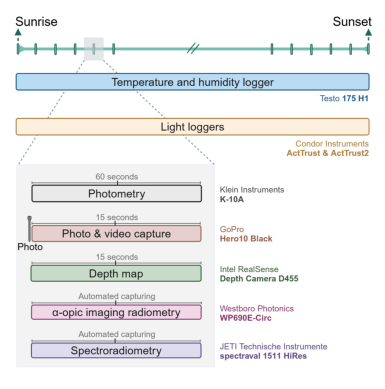

In [328]:
setup_diagram = mpimg.imread(f'{spatial_paper_dir}//Measurement_setup.png')

plt.imshow(setup_diagram)
plt.axis('off'); 

## Figure 0-b (Table of measurements)


In [254]:


# Create a modified DataFrame with placeholders for missing view categories
full_data = []
for location in locations:
    for view in views:
        # Filter data for the current location and view category
        subset = merged_wp_jeti_metadata_df[
            (merged_wp_jeti_metadata_df['location'] == location) & (merged_wp_jeti_metadata_df['view'] == view)
        ]
        if subset.empty:
            # Add a placeholder row if no data exists for this location and view
            full_data.append({
                "location": location,
                "view": view,
                "X v,mel,D65 (MEDI) [lx]": np.nan  # Placeholder value
            })
        else:
            # Keep the existing data
            full_data.extend(subset.to_dict('records'))

# Create a complete DataFrame
complete_df = pd.DataFrame(full_data)

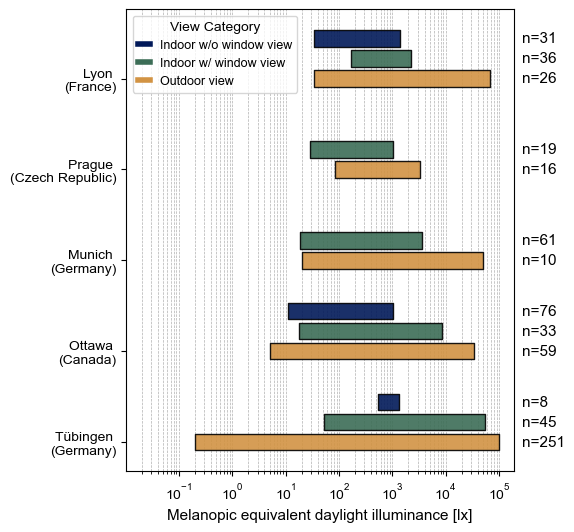

In [337]:

# Group data by location and view
grouped_data = [
    complete_df[
        (complete_df['location'] == location) & (complete_df['view'] == view)
    ]["X v,mel,D65 (MEDI) [lx]"].dropna().values
    for location in locations
    for view in views
]

# Prepare positions and ranges
offset = 0.22  # Adjust this for spacing
data_to_plot = []
x_positions = []
counts = []
for loc_index, location in enumerate(locations):
    for view_index, view in enumerate(views):
        # Filter data
        view_data = complete_df[
            (complete_df['location'] == location) & (complete_df['view'] == view)
        ]["X v,mel,D65 (MEDI) [lx]"].dropna()

        if view_data.empty:
            # Placeholder for missing category
            x_positions.append(loc_index + view_index * offset)
            data_to_plot.append((0, 0))  # No bar
            counts.append(0)
        else:
            # Add real data
            min_val = view_data.min()
            max_val = view_data.max()
            x_positions.append(loc_index + view_index * offset)
            data_to_plot.append((min_val, max_val - min_val))
            counts.append(len(view_data))
# Set up the plot with flipped axes
plt.figure(figsize=(5, 6))
# Define a fixed x-position for all annotations to align them in a single line
annotation_x_position = max([start + width for start, width in data_to_plot
                             ]) * 2.7  # Adjust as needed

# Plot as usual, leaving empty spaces where counts are 0
for i, (start, width) in enumerate(data_to_plot):
    if counts[i] == 0:
        continue  # Skip empty bars
    # Determine the view category based on forced order
    view = views[i % len(views)]  # Get the view name based on index
    color = view_color_mapping[view]  # Use the correct color for the category
    
    # Plot the bar
    plt.broken_barh([(start, width)], (x_positions[i] - 0.09, 0.18),
                    facecolors=color, edgecolor='black', alpha=0.9, zorder=3)
     # Annotate with the count of data points, aligned to the right
    plt.text(annotation_x_position,
             x_positions[i],
             f'n={counts[i]}',
             va='center',
             ha='left',
             fontsize=11)

# Create the legend with the forced order
handles = [
    plt.Line2D([0], [0], color=view_color_mapping[view], lw=4, label=view)
    for view in ['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view']
]
legend = plt.legend(handles=handles, title="View Category", loc='upper left',
                    bbox_to_anchor=(0, 1), fontsize=9, title_fontsize=10, handlelength=1)

# Modify location labels to split into two lines
formatted_locations = [loc.replace("(", "\n(") for loc in complete_df['location'].unique()]

# Set y-ticks to the formatted locations
plt.yticks(np.arange(len(complete_df['location'].unique())), formatted_locations, fontsize=10)

# Add labels and title
plt.xlabel("Melanopic equivalent daylight illuminance [lx]", fontsize=11)
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, zorder=0)

# Set the x-axis to a logarithmic scale
plt.xscale('log')
# Add padding to the left side
current_xlim = plt.gca().get_xlim()
plt.gca().set_xlim(left=current_xlim[0] * 0.1, right=current_xlim[1])

# Modify grid and tick settings
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, zorder=0)  # Both major and minor grids

plt.savefig(
    f'{spatial_paper_dir}//broken_bar_plot_mEDI_logscale_location.png',
    dpi=600, bbox_inches='tight');

## Figure 0-c (Histogram of overexposed pixels)
the ipRGC plot here and other channels in the `supplementary` section

In [322]:
# Total number of pixels per image
total_pixels = 9188256

# Initialize the results list
results = []

# Group by the 'view' category
for view, group_df in merged_wp_jeti_metadata_df.groupby('view'):
    # Calculate the overexposed percentage for the current group
    overexposed_percentages = (
        (group_df['overexposed_pixels_Melanopsin'].astype(float) / total_pixels) * 100
    )
    
    # Count the measurements exceeding the thresholds
    over_1_percent = (overexposed_percentages > 1).sum()
    over_10_percent = (overexposed_percentages > 10).sum()
    over_25_percent = (overexposed_percentages > 25).sum()
    
    # Get the timestamps for the measurements with more than 25% overexposed pixels
    timestamps_over_25_percent = group_df['timestamp'][overexposed_percentages > 25].tolist()
    
    # Append the results for this view to the list
    results.append({
        'view': view,
        'over_1_percent_overexposed_pixels': over_1_percent,
        'over_10_percent_overexposed_pixels': over_10_percent,
        'over_25_percent_overexposed_pixels': over_25_percent
    })

# Convert the results list into a DataFrame
overexposed_percentage_per_view_df = pd.DataFrame(results)
print(f"This image has more than 25% overexposed pixels: {timestamps_over_25_percent}")

This image has more than 25% overexposed pixels: ['20240322T1530']


In [324]:
overexposed_percentage_per_view_df

view  over_1_percent_overexposed_pixels  \
0   Indoor w/ window view                                  5   
1  Indoor w/o window view                                  0   
2            Outdoor view                                 36   

   over_10_percent_overexposed_pixels  over_25_percent_overexposed_pixels  
0                                   1                                   0  
1                                   0                                   0  
2                                  19                                   1

In [323]:
# Save the DataFrame to a CSV file

overexposed_percentage_per_view_df.to_csv(
    f'{spatial_paper_dir}\\overexposed_percentage_per_view.csv',
    sep=',',
    index=True)

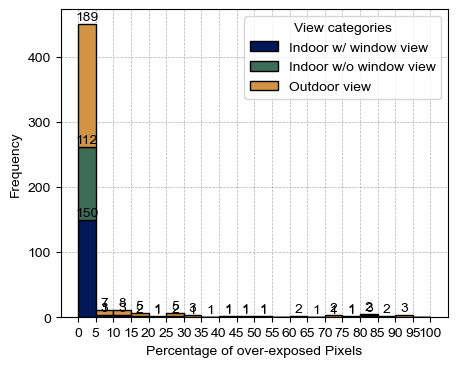

In [302]:
# not using it

# Total number of pixels per image
total_pixels = 9188256
offset = 1

for view, group_df in merged_wp_jeti_metadata_df.groupby('view'):
    # Calculate the percentage of overexposed pixels on-the-fly
    overexposed_percentage = (group_df['overexposed_pixels_Melanopsin'].astype(float) / total_pixels) * 100

# Define the number of bins for the histogram
bins = [i for i in range(0, 101, 5)]  # Bins from 0 to 100%

# Plot stacked histograms
plt.figure(figsize=(5, 4))
n, _, patches = plt.hist(data_to_plot,
                         bins=bins,
                         stacked=True,
                         color=cmap_colors,
                         edgecolor='black',
                         label=[f'{name}' for name in grouped.groups.keys()],
                         zorder=2)

# Customize the plot
#plt.title('Stacked Histogram of Percentage of Invalid Pixels by View')
plt.xlabel('Percentage of over-exposed Pixels')
plt.ylabel('Frequency')
plt.legend(title='View categories')
plt.grid(True, linestyle='--', linewidth=0.5, zorder=0)

# Set the x-axis ticks to correspond to the bin edges
plt.xticks(bins)

# Annotate the plot with frequencies above each bin
# Get the heights of the bars
for i in range(len(patches)):
    for j in range(len(patches[i])):
        height = patches[i][j].get_height()  # Height of the bar
        if height > 0:  # Only annotate if there's a bar
            plt.text(
                patches[i][j].get_x() + patches[i][j].get_width() / 2,
                patches[i][j].get_y() + height +
                offset,  # Positioning just above the bar
                f'{int(height)}',
                ha='center',
                va='bottom',
                color='black')
plt.savefig(
    f'{spatial_paper_dir}//Overexposed_pixels_per_view.png',
    dpi=600, bbox_inches='tight');

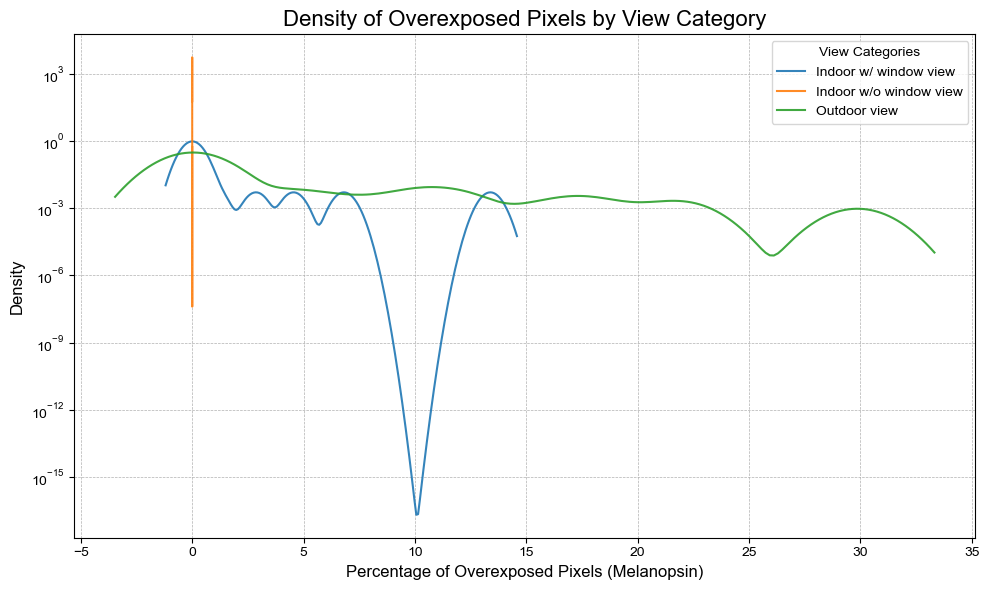

In [309]:
#Density plot

# Total number of pixels per image
total_pixels = 9188256

# Density plot for each view category
plt.figure(figsize=(10, 6))
# Loop through each group in the DataFrame grouped by 'view'
for view, group_df in merged_wp_jeti_metadata_df.groupby('view'):
    # Calculate the percentage of overexposed pixels on-the-fly
    overexposed_percentage = (group_df['overexposed_pixels_Melanopsin'].astype(float) / total_pixels) * 100

    # Plot density using Seaborn's kdeplot
    sns.kdeplot(
        data=overexposed_percentage, 
        label=view, 
        fill=False,   # Traditional density lines
        alpha=0.9,    # Line transparency
        zorder=2      # Ensures lines are above gridlines
    )
# Set x-axis to logarithmic scale
#plt.xscale('log')
plt.yscale('log')
# Add title and labels
plt.title('Density of Overexposed Pixels by View Category', fontsize=16)
plt.xlabel('Percentage of Overexposed Pixels (Melanopsin)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='View Categories')

plt.grid(True, linestyle='--', linewidth=0.5, zorder = 0)

# Show the plot
plt.tight_layout()



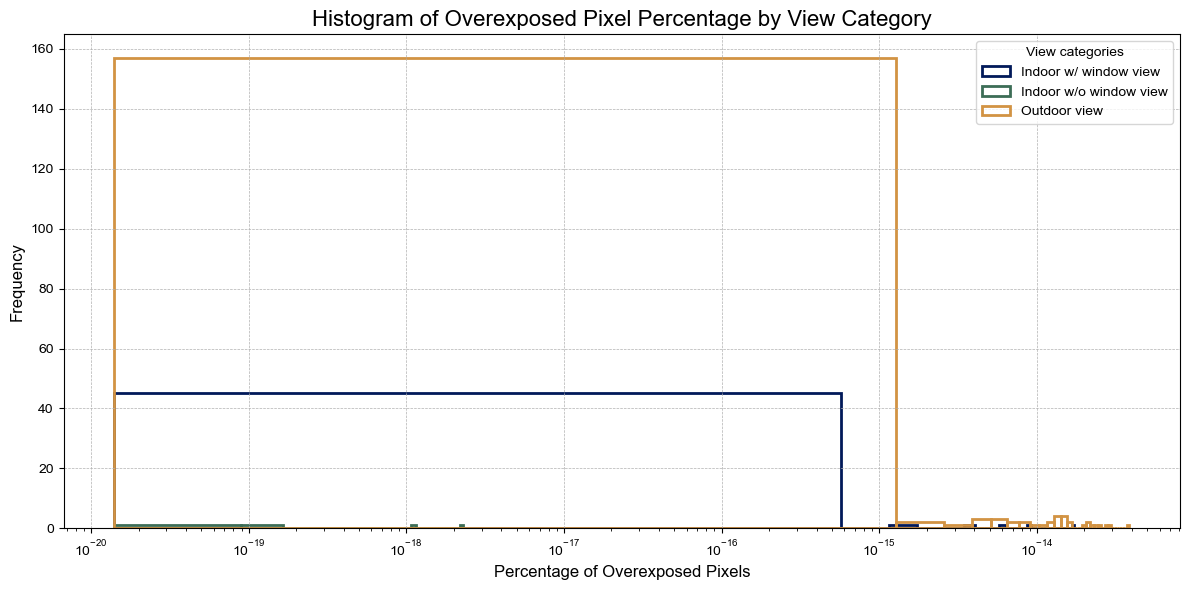

In [270]:
# Total number of pixels in each image
total_pixels = 9188256


# Set up the figure
plt.figure(figsize=(12, 6))

# Loop through each group in the DataFrame grouped by 'view'
for i, (view, group_df) in enumerate(merged_wp_jeti_metadata_df.groupby('view')):
    # Calculate the percentage of overexposed pixels on-the-fly
    overexposed_percentage = (group_df['overexposed_pixels_Melanopsin'] / total_pixels) * 100
    overexposed_percentage = overexposed_percentage[overexposed_percentage > 0]
    # Plot histogram for each view category
    sns.histplot(
        overexposed_percentage, 
        kde=False,  # Disable KDE for a true histogram
        bins=30,    # Number of bins
        label=view,
        alpha=0,   # Transparency for overlapping bars
        edgecolor=cmap_colors[i],
        linewidth=2
    )
plt.xscale('log')
# Add title and labels
plt.title('Histogram of Overexposed Pixel Percentage by View Category', fontsize=16)
plt.xlabel('Percentage of Overexposed Pixels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
#plt.title('Density Plot of Invalid Pixels by View Category')
plt.legend(title='View categories')
plt.grid(True, linestyle='--', linewidth=0.5, zorder = 0)

# Show the plot
plt.tight_layout()


In [ ]:

# Annotate the plot with frequencies above each bin
# Get the heights of the bars
for i in range(len(patches)):
    for j in range(len(patches[i])):
        height = patches[i][j].get_height()  # Height of the bar
        if height > 0:  # Only annotate if there's a bar
            plt.text(patches[i][j].get_x() + patches[i][j].get_width() / 2, 
                     patches[i][j].get_y() +  height + offset,  # Positioning just above the bar
                     f'{int(height)}', 
                     ha='center', va='bottom', color='black')

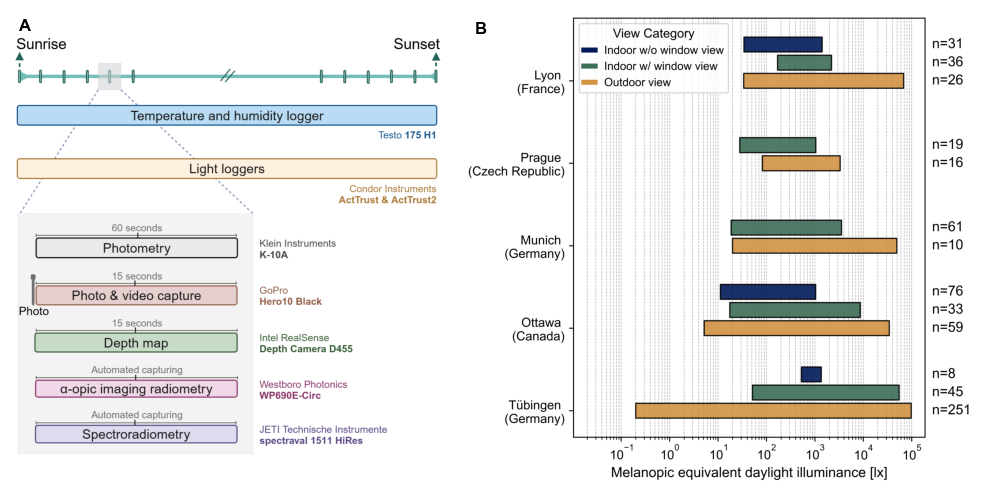

In [343]:
# Figure Zero

# Create a new figure for combining the plots
combined_fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 6])  # Adjust grid for layout

# Load and display the first figure
ax1 = combined_fig.add_subplot(gs[0, 0])  # Both rows, first column
img1 = mpimg.imread(f'{spatial_paper_dir}//Measurement_setup.png')  
ax1.imshow(img1)
ax1.axis('off')  # Hide the axes
ax1.text(0.02, 1, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold', color='black')

# Load and display the second figure
ax2 = combined_fig.add_subplot(gs[0, 1])  # First row, second column
img2 = mpimg.imread(f'{spatial_paper_dir}//broken_bar_plot_mEDI_logscale_location.png') 
ax2.imshow(img2)
ax2.axis('off')  # Hide the axes
ax2.text(0.03, 0.95, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold', color='black')


# Load and display the third figure
#ax3 = combined_fig.add_subplot(gs[1, 1])  # Second row, spanning two columns
#img3 = mpimg.imread(f'{spatial_paper_dir}//Overexposed_pixels_per_view.png')  
#ax3.imshow(img3)
#ax3.axis('off')  # Hide the axes
#ax3.text(0.02, 0.99, 'C', transform=ax3.transAxes, fontsize=12, fontweight='bold', color='black')


# Adjust layout to prevent overlap
plt.tight_layout()

plt.subplots_adjust(hspace=0.1)  
plt.savefig(
    f'{spatial_paper_dir}//Figure0.png',
    dpi=600,
    bbox_inches='tight')
plt.savefig(
    f'{spatial_paper_dir}//Figure0.tiff',
    dpi=600,
    bbox_inches='tight');


# Figure One

## Figure 1-a (Scatter plot with marginal histograms)
x axis: Photopic lux, y axis: Melanopic EDI  for each `view` category from `Jeti`

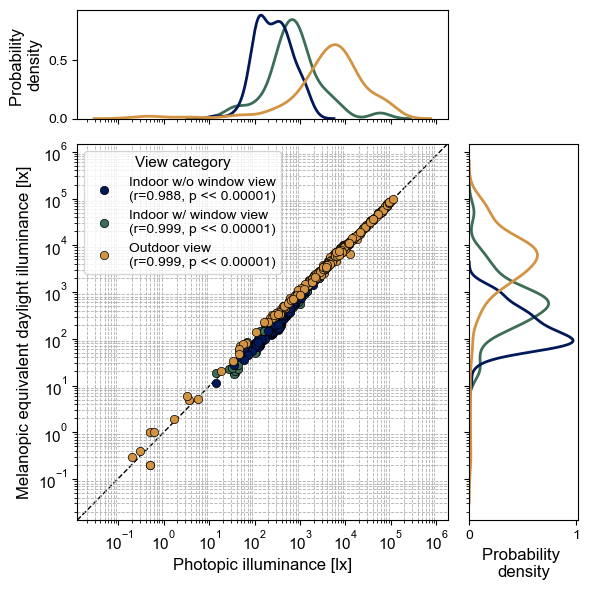

In [209]:
# Probability density and Mel EDI

# Create the figure with gridspec for scatter plot and histograms
fig1 = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Create the main scatter plot area
ax_main = fig1.add_subplot(gs[1:4, 0:3])

# Create the KDE for the x-axis on top
ax_x_kde = fig1.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the KDE for the y-axis on the right
ax_y_kde = fig1.add_subplot(gs[1:4, 3], sharey=ax_main)

# Create an empty dictionary to track plotted groups
plotted_groups = {}
# Loop through the groups and plot the scatter points
for group, group_df in merged_wp_jeti_metadata_df.groupby('view'):

    x_values = group_df['Illuminance [lx] (CIE1931 2°)']
    y_values = group_df['X v,mel,D65 (MEDI) [lx]']

    # Calculate the correlation coefficient (r) and p-value
    r, p = stats.pearsonr(x_values, y_values)
    if p < 0.00001:
        label = f"{group}\n(r={r:.3f}, p << 0.00001)"
    else:
        label = f"{group}\n(r={r:.3f}, p={p:.2e})"

    # Scatter plot for each group
    ax_main.scatter(x_values,
                    y_values,
                    label=label,
                    color=view_color_mapping[group],
                    edgecolors='black',
                    linewidth=0.5,
                    zorder=2)
    # Track the group and label for custom legend
    plotted_groups[group] = label  
    
    # KDE plot on the x-axis
    sns.kdeplot(x=x_values,
                ax=ax_x_kde,
                color=view_color_mapping[group],
                log_scale=True,
                linewidth=2)

    # KDE plot on the y-axis, using the `y` argument
    sns.kdeplot(y=y_values,
                ax=ax_y_kde,
                color=view_color_mapping[group],
                log_scale=True,
                linewidth=2)

ax_main.tick_params(axis='x', labelsize=11)
ax_main.tick_params(axis='y', labelsize=11)

# Set labels for the scatter plot
ax_main.set_xlabel('Photopic illuminance [lx]', fontsize=12)
ax_main.set_ylabel('Melanopic equivalent daylight illuminance [lx]',
                   fontsize=12)
ax_main.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)
# Create a custom legend to enforce the order
custom_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color=view_color_mapping[view],
        label=plotted_groups[view],
        markersize=6,
        linestyle='None',
        markeredgecolor='black',
        markeredgewidth=0.5
    )
    for view in ['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view']
]
ax_main.legend(handles=custom_handles, title="View category",
               loc='upper left',
               title_fontsize=11,
               fontsize=10)

# Hide labels for the KDEs (x and y)
ax_x_kde.set_xlabel('')  # Remove x-axis label for top KDE
ax_y_kde.set_ylabel('')  # Remove y-axis label for right KDE

ax_x_kde.tick_params(axis='x', which='both', labelbottom=False,
                     labelsize=12)  # Hide x-axis tick labels for top KDE
ax_y_kde.tick_params(axis='y', which='both', labelleft=False,
                     labelsize=12)  # Hide y-axis tick labels for right KDE

# Set axis labels for both KDEs
ax_x_kde.set_ylabel('Probability \ndensity', fontsize=12, font='Arial')
ax_y_kde.set_xlabel('Probability \ndensity', fontsize=12, font='Arial')

# Ensure log scale is set for the KDEs
ax_x_kde.set_xscale('log')
ax_y_kde.set_yscale('log')
# Add a dashed diagonal line
line = Line2D(
    [0, 1],  # Start and end in normalized figure coordinates (diagonal)
    [0, 1],
    linestyle='--',
    color='black',
    linewidth=1,
    transform=ax_main.transAxes,  # Use Axes coordinate system
    zorder=1)
ax_main.add_line(line)
# Add grid to the KDEs for visibility
#ax_x_kde.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)

#ax_y_kde.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)

plt.tight_layout()
plt.savefig(
    f'{spatial_paper_dir}//MelEDI_vr_illuminance_logscale_KDE_jeti.png',
    dpi=600,
    bbox_inches='tight')

## Figure 1-b (Scatter plot with marginal histograms)
x axis:  Melanopic EDI from Jeti, y axis: mean melanopic luminance from Westboro for each `view` category (I should calculate melanopic luminance from radiance with the LuxPy package)

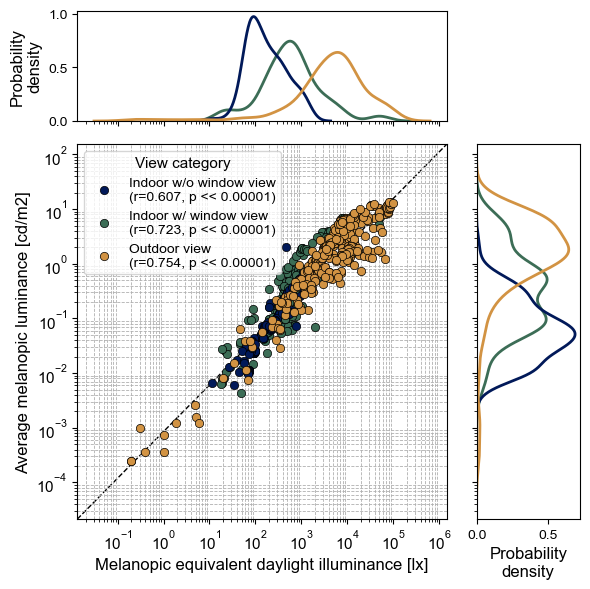

In [210]:

# Create the figure with gridspec for scatter plot and histograms (.replace(0, 1e-3))
fig2 = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)  # 4x4 grid


# Create the main scatter plot area
ax_main = fig2.add_subplot(gs[1:4, 0:3])

# Create the KDE for the x-axis on top
ax_x_kde = fig2.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the KDE for the y-axis on the right
ax_y_kde = fig2.add_subplot(gs[1:4, 3], sharey=ax_main)

plotted_groups = {}
# Loop through the groups and plot the scatter points
for group, group_df in merged_wp_jeti_metadata_df.groupby('view'):
    
    x_values = group_df['X v,mel,D65 (MEDI) [lx]']
    y_values = group_df['average_luminance_Melanopsin']
    
    # Calculate the correlation coefficient (r) and p-value
    r, p = stats.pearsonr(x_values, y_values) 
    
    if p < 0.00001:
        label = f"{group}\n(r={r:.3f}, p << 0.00001)"
    else:
        label = f"{group}\n(r={r:.3f}, p={p:.2e})"
    # Scatter plot for each group
    ax_main.scatter(x_values, y_values, label=label, color=view_color_mapping[group], edgecolors='black', linewidth=0.5, zorder =2 )
    # Track the group and label for custom legend
    plotted_groups[group] = label
    
    # KDE plot on the x-axis
    sns.kdeplot(x=x_values, ax=ax_x_kde, color=view_color_mapping[group], log_scale=True, linewidth=2)

    # KDE plot on the y-axis, using the `y` argument
    sns.kdeplot(y=y_values, ax=ax_y_kde, color=view_color_mapping[group], log_scale=True, linewidth=2)

# Set log scale for both x and y axes on the main scatter plot
ax_main.set_xscale('log')
ax_main.set_yscale('log')

ax_main.tick_params(axis='x', labelsize=11)  
ax_main.tick_params(axis='y', labelsize=11)
# Set labels for scatter plot
ax_main.set_xlabel('Melanopic equivalent daylight illuminance [lx]',fontsize=12)
ax_main.set_ylabel('Average melanopic luminance [cd/m2]',fontsize=12)
ax_main.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)
# Create a custom legend to enforce the order
custom_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color=view_color_mapping[view],
        label=plotted_groups[view],
        markersize=6,
        linestyle='None',
        markeredgecolor='black',
        markeredgewidth=0.5
    )
    for view in ['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view']
]
ax_main.legend(handles=custom_handles, title='View category', loc='upper left', title_fontsize=11, fontsize = 10)

# Hide labels for the KDEs (x and y)
ax_x_kde.set_xlabel('')  # Remove x-axis label for top KDE
ax_y_kde.set_ylabel('')  # Remove y-axis label for right KDE


ax_x_kde.tick_params(axis='x', which='both', labelbottom=False, labelsize=12)  # Hide x-axis tick labels for top KDE
ax_y_kde.tick_params(axis='y', which='both', labelleft=False, labelsize=12)    # Hide y-axis tick labels for right KDE
# Set axis labels for both KDEs
ax_x_kde.set_ylabel('Probability\ndensity', fontsize=12, font='Arial')
ax_y_kde.set_xlabel('Probability\ndensity', fontsize=12, font='Arial')

# Ensure log scale is set for the KDEs
ax_x_kde.set_xscale('log')
ax_y_kde.set_yscale('log')
# Add a dashed diagonal line
line = Line2D(
    [0, 1],  # Start and end in normalized figure coordinates (diagonal)
    [0, 1], 
    linestyle='--', 
    color='black', 
    linewidth=1, 
    transform=ax_main.transAxes,  # Use Axes coordinate system
    zorder=1
)
ax_main.add_line(line)
# Add grid to the KDEs for visibility
#ax_x_kde.grid(True, which='minor', linestyle='--', linewidth=0.6)
#ax_y_kde.grid(True, which='minor', linestyle='--', linewidth=0.6)

plt.tight_layout()

plt.savefig(f'{spatial_paper_dir}//Wp_vr_jeti_KDE_logscale.png',dpi=600,
    bbox_inches='tight');

## Figure 1-c (Correlation matrix all alpha-opic from Jeti)

In [246]:
#EDI (I neeed to calculate EDI from merged_wp_jeti_metadata_df[['Esc [W/sqm]', 'Emc [W/sqm]', 'Elc [W/sqm]', 'Erh [W/sqm]', 'Emel [W/sqm]']])
corr_matrix = merged_wp_jeti_metadata_df[['Elc [W/sqm]','Emc [W/sqm]','Esc [W/sqm]', 'Erh [W/sqm]', 'Emel [W/sqm]']].corr()
corr_matrix

Elc [W/sqm]  Emc [W/sqm]  Esc [W/sqm]  Erh [W/sqm]  Emel [W/sqm]
Elc [W/sqm]      1.000000     0.999883     0.994893     0.999202      0.998698
Emc [W/sqm]      0.999883     1.000000     0.996179     0.999679      0.999330
Esc [W/sqm]      0.994893     0.996179     1.000000     0.998031      0.998665
Erh [W/sqm]      0.999202     0.999679     0.998031     1.000000      0.999934
Emel [W/sqm]     0.998698     0.999330     0.998665     0.999934      1.000000

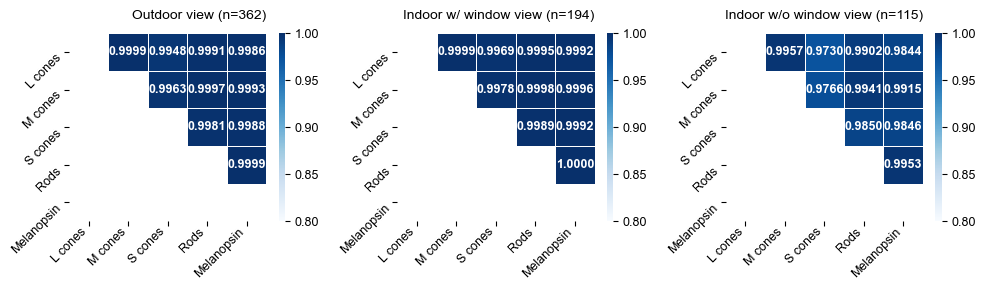

In [251]:

merged_wp_jeti_metadata_df_renamed = merged_wp_jeti_metadata_df.rename(columns={
    'Elc [W/sqm]': 'L cones',
    'Emc [W/sqm]': 'M cones',
    'Esc [W/sqm]': 'S cones', 
    'Erh [W/sqm]': 'Rods', 
    'Emel [W/sqm]': 'Melanopsin'
})
variables = [
    'L cones',
    'M cones',
    'S cones', 
    'Rods', 
    'Melanopsin'
]

# Get unique view categories
views = merged_wp_jeti_metadata_df_renamed['view'].unique()

# Set up the figure
fig3 = plt.figure(figsize=(10, 3))
# Get the positions of the ticks for both x and y axes
xticks_pos = np.arange(len(variables))  # Default positions of the ticks
yticks_pos = np.arange(len(variables))  # Default positions of the ticks
# Create subplots for each view category
for i, view in enumerate(views):
    # Filter the DataFrame for the current view category
    view_data = merged_wp_jeti_metadata_df_renamed[merged_wp_jeti_metadata_df_renamed['view'] == view]

    # Calculate the correlation matrix
    corr_matrix_wp = view_data[variables].corr()

    mask = np.tril(np.ones_like(corr_matrix_wp, dtype=bool), k=0)

    # Create a subplot for the correlation matrix
    plt.subplot(1, len(views), i + 1)
    sns.heatmap(
        corr_matrix_wp,
        annot=True,
        fmt=".4f",
        cmap="Blues",
        vmin=0.8,
        vmax=1,
        linewidths=0.7,
        linecolor='white',
        mask=mask,
        annot_kws={'size': 9, 'weight':'bold'},
        cbar_kws={
            'aspect': 30,
            'shrink': 1
        },
    )
    colorbar = plt.gca().collections[0].colorbar
    colorbar.ax.tick_params(labelsize=9)
    colorbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    # Add the number of data points (n) in the title
    n_data_points = len(view_data)
    plt.title(f'{view} (n={n_data_points})', pad=10, fontsize=10, loc='right')
    # Get the width of the tick boxes (this will give an idea of their size)
    xtick_width = xticks_pos[1] - xticks_pos[0]  # Difference between two consecutive tick positions (assuming equal spacing)
    ytick_height = yticks_pos[1] - yticks_pos[0]  # Same for y-ticks
    
    # Set the tick labels using the 'variables' list
    plt.xticks(ticks=xticks_pos + xtick_width / 2, labels=variables, rotation=45, ha='right' ,font= "Arial")
    plt.yticks(ticks=yticks_pos + ytick_height / 2, labels=variables, rotation=45, ha='right',font= "Arial" )
    
    ax = plt.gca()
    ax.tick_params(axis='x', labelsize=9, pad=0.1)  # Adjust pad to bring x-axis labels closer
    ax.tick_params(axis='y', labelsize=9, pad=0.1) 
    # Adjust the y-tick label positions
    for label in plt.gca().get_yticklabels():
        label.set_verticalalignment('top')
        
plt.tight_layout()
plt.savefig(
    f'{spatial_paper_dir}//Correlation_matrix_α-opics_radiance_per_view.png',
    dpi=600,
    bbox_inches='tight')


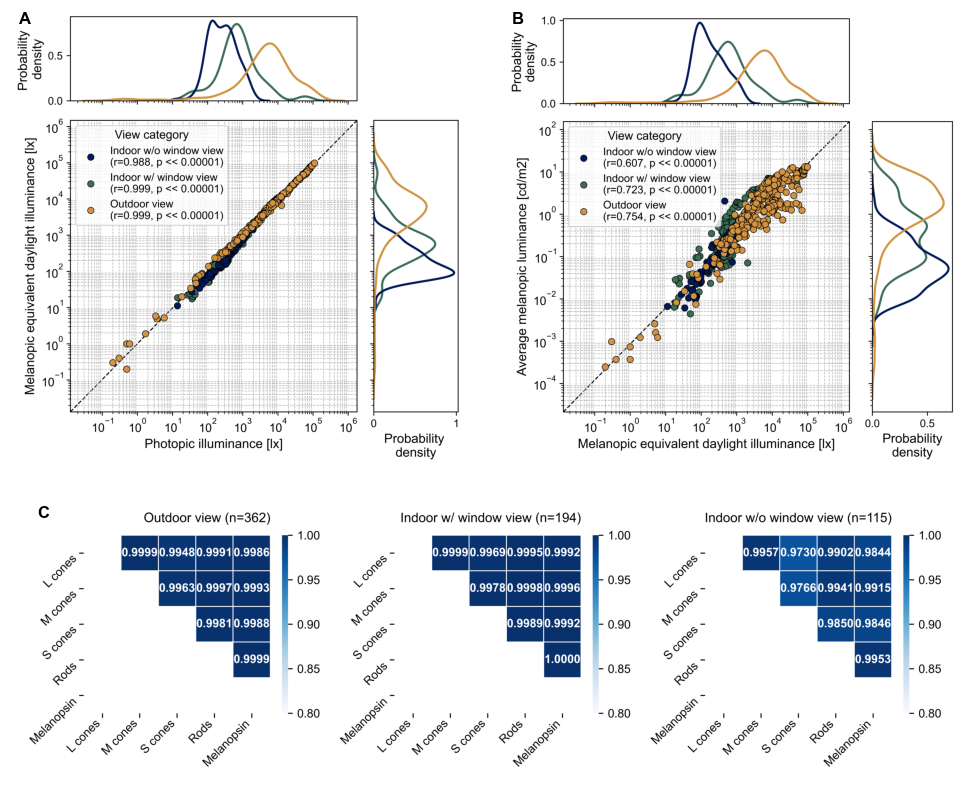

In [252]:
# Create a new figure for combining the plots
combined_fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[5, 3])  # Create a grid for layout

# Load and display the first figure
ax1 = combined_fig.add_subplot(gs[0, 0])  # First row, first column
img1 = mpimg.imread(f'{spatial_paper_dir}/MelEDI_vr_illuminance_logscale_KDE_jeti.png')
ax1.imshow(img1)
ax1.axis('off')  # Hide the axes
ax1.text(0.02, 0.97, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold', color='black')


# Load and display the second figure
ax2 = combined_fig.add_subplot(gs[0, 1])  # First row, second column
img2 = mpimg.imread(f'{spatial_paper_dir}/Wp_vr_jeti_KDE_logscale.png') 
ax2.imshow(img2)
ax2.axis('off')  # Hide the axes
ax2.text(0.02, 0.97, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold', color='black')


# Load and display the third figure
ax3 = combined_fig.add_subplot(gs[1, :])  # Second row, spanning two columns
img3 = mpimg.imread(f'{spatial_paper_dir}/Correlation_matrix_α-opics_radiance_per_view.png')  
ax3.imshow(img3)
ax3.axis('off')  # Hide the axes
ax3.text(0.02, 0.95, 'C', transform=ax3.transAxes, fontsize=12, fontweight='bold', color='black')


# Adjust layout to prevent overlap
plt.tight_layout()

plt.subplots_adjust(hspace=0.1)  
plt.savefig(
    f'{spatial_paper_dir}//Figure1.png',
    dpi=600,
    bbox_inches='tight')
plt.savefig(
    f'{spatial_paper_dir}//Figure1.tiff',
    dpi=600,
    bbox_inches='tight');


# Figure Two

## Figure 2-a (Correlation matrix all average radiance α-opics from Westboro)

In [57]:
corr_matrix_wp_average = merged_wp_jeti_metadata_df.filter(like='average_radiances').corr()
corr_matrix_wp_average

average_radiances_L cones  \
average_radiances_L cones                      1.000000   
average_radiances_M cones                      0.956752   
average_radiances_S cones                      0.937844   
average_radiances_Rods                         0.988199   
average_radiances_Melanopsin                   0.978669   

                              average_radiances_M cones  \
average_radiances_L cones                      0.956752   
average_radiances_M cones                      1.000000   
average_radiances_S cones                      0.991958   
average_radiances_Rods                         0.920191   
average_radiances_Melanopsin                   0.986640   

                              average_radiances_S cones  \
average_radiances_L cones                      0.937844   
average_radiances_M cones                      0.991958   
average_radiances_S cones                      1.000000   
average_radiances_Rods                         0.906516   
average_radiances_Melanopsin                   0.978192   

                              average_radiances_Rods  \
average_radiances_L cones                   0.988199   
average_radiances_M cones                   0.920191   
average_radiances_S cones                   0.906516   
average_radiances_Rods                      1.000000   
average_radiances_Melanopsin                0.954491   

                              average_radiances_Melanopsin  
average_radiances_L cones                         0.978669  
average_radiances_M cones                         0.986640  
average_radiances_S cones                         0.978192  
average_radiances_Rods                            0.954491  
average_radiances_Melanopsin                      1.000000

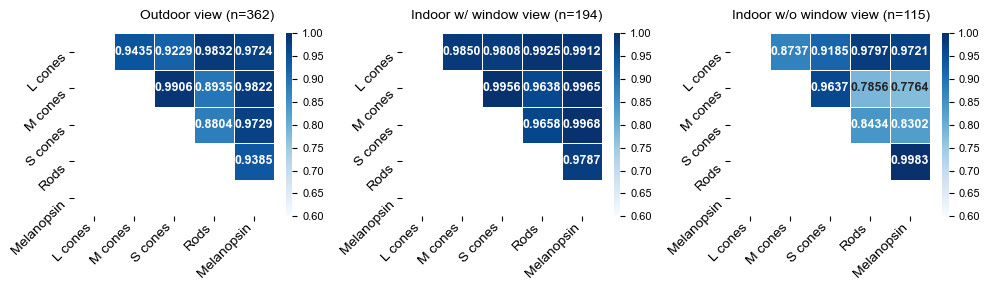

In [64]:

n_data_points_dict = {}
# Set up the figure
plt.figure(figsize=(10, 3))

# Create subplots for each view category
for i, view in enumerate(views):
    # Filter the DataFrame for the current view category
    view_data = merged_wp_jeti_metadata_df[merged_wp_jeti_metadata_df['view'] == view]

    # Calculate the correlation matrix for columns starting with 'average'
    corr_matrix_wp = view_data.filter(like='average_radiances').corr()

    mask = np.tril(np.ones_like(corr_matrix_wp, dtype=bool), k=0)

    # Create a subplot for the correlation matrix
    plt.subplot(1, len(views), i + 1)
    sns.heatmap(
        corr_matrix_wp,
        annot=True,
        fmt=".4f",
        cmap="Blues",
        vmin=0.6,
        vmax=1,
        linewidths=0.7,
        linecolor='white',
        mask=mask,
        annot_kws={'size': 9, 'weight':'bold'},
        cbar_kws={
            'aspect': 30,
            'shrink': 1
        },
        xticklabels=[name.split('_')[-1] for name in corr_matrix_wp.columns],
        yticklabels=[name.split('_')[-1] for name in corr_matrix_wp.index])
    colorbar = plt.gca().collections[0].colorbar
    colorbar.ax.tick_params(labelsize=8)

    # Add the number of data points (n) in the title
    n_data_points = len(view_data)
    plt.title(f'{view} (n={n_data_points})', pad=10, fontsize=10, loc='right')
    n_data_points_dict[view] = n_data_points
    # Set tick parameters for both axes to ensure proximity and font size
    plt.gca().tick_params(axis='x', labelsize=9, pad=0.1)  # Adjust `pad` for x-axis
    plt.gca().tick_params(axis='y', labelsize=9, pad=0.1)  # Adjust `pad` for y-axis

    # Adjust x and y ticks: font size and alignment to the tick marks
    plt.xticks(rotation=45, ha='right',fontsize=10)  # X-tick labels end aligned at tick
    plt.yticks(rotation=45, va='top', fontsize=10)    # Y-tick labels end aligned at tick
    plt.tight_layout()

plt.savefig(
    f'{spatial_paper_dir}//Correlation_matrix_α-opics_average_radiances_per_view.png',
    dpi=600,
    bbox_inches='tight');

## Correlation of pixel by pixel

In [212]:
average_pixels_correlation_df = pd.read_csv(
    f'{spatial_paper_dir}//average_pixels_correlation_df.csv')



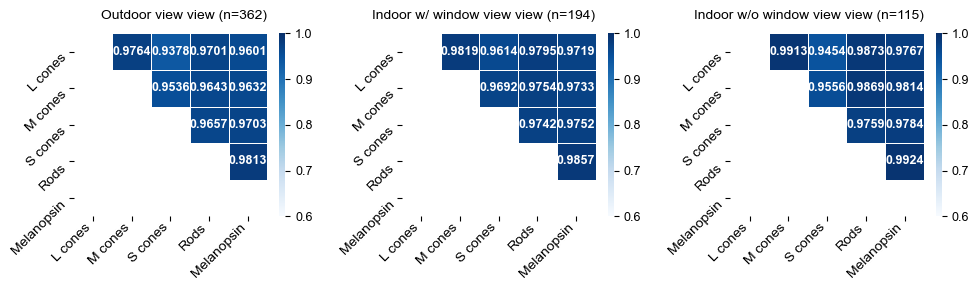

In [214]:
# Unique categories from the data
pixels_views = average_pixels_correlation_df['view'].unique()

# Create a figure for subplots
plt.figure(figsize=(10, 3))

# Loop through each view and plot its correlation matrix
for i, view in enumerate(pixels_views):
    # Filter and pivot data for the current view
    category_data = average_pixels_correlation_df[average_pixels_correlation_df['view'] == view]
    corr_matrix_wp = category_data.pivot(index='Row', columns='Column', values='Value')
    # Ensure the tick order
    ordered_ticks = ['L cones', 'M cones', 'S cones', 'Rods', 'Melanopsin']
    corr_matrix_wp = corr_matrix_wp.loc[ordered_ticks, ordered_ticks]
    
    # Create mask for lower triangle
    mask = np.tril(np.ones_like(corr_matrix_wp, dtype=bool), k=0)
    
    # Create a subplot for the correlation matrix
    plt.subplot(1, len(pixels_views), i + 1)
    sns.heatmap(
        corr_matrix_wp,
        annot=True,
        fmt=".4f",
        cmap="Blues",
        vmin=0.6,
        vmax=1,
        linewidths=0.7,
        linecolor='white',
        mask=mask,
        annot_kws={'size': 9, 'weight':'bold'},
        cbar_kws={
            'aspect': 30,
            'shrink': 1
        },
        xticklabels=ordered_ticks, 
        yticklabels=ordered_ticks 
    )
    # Remove axis labels explicitly
    plt.xlabel("")
    plt.ylabel("")
    
    # Customize colorbar
    colorbar = plt.gca().collections[0].colorbar
    colorbar.ax.tick_params(labelsize=9)
    
    # Set title for each subplot
    plt.title(f'{view} view (n={n_data_points_dict.get(view)})', pad=10, fontsize=10, loc='right')
    
    # Set tick parameters for both axes
    plt.gca().tick_params(axis='x', labelsize=9, pad=0.1)
    plt.gca().tick_params(axis='y', labelsize=9, pad=0.1)
    
    # Adjust ticks alignment
    plt.xticks(rotation=45, ha='right',fontsize=10)  # Align x-tick labels
    plt.yticks(rotation=45, va='top',fontsize=10)    # Align y-tick labels

# Ensure layout fits well
plt.tight_layout()

plt.savefig(
    f'{spatial_paper_dir}//Correlation_matrix_α-opics_pixel_by_pixel_per_view.png',
    dpi=600,
    bbox_inches='tight');

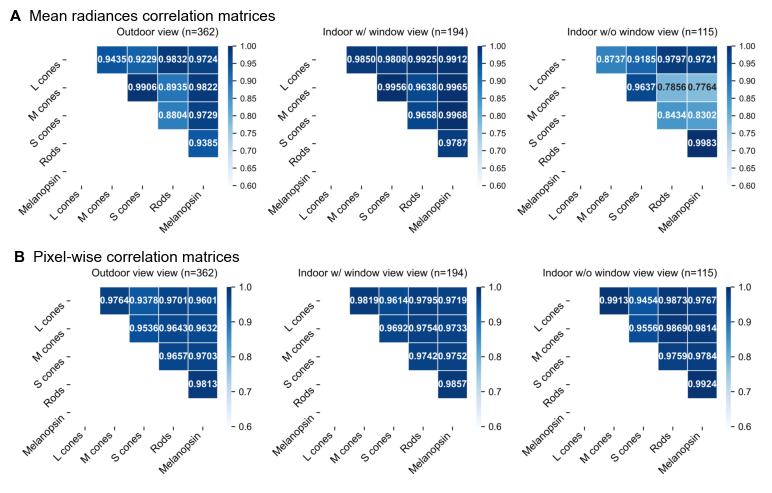

In [234]:
# Figure 2

# Create a figure with the specified size
combined_fig = plt.figure(figsize=(10, 6))

# Define the grid layout: 2 rows and 2 columns, with adjusted height and width ratios
gs = gridspec.GridSpec(
    2,
    1,
    height_ratios=[1, 1]
)

# Load and display the first figure
ax1 = combined_fig.add_subplot(gs[0, 0]) 
img1 = mpimg.imread(f'{spatial_paper_dir}/Correlation_matrix_α-opics_average_radiances_per_view.png')
ax1.imshow(img1)
ax1.axis('off')  # Hide the axes
ax1.text(0.0, 1, 'A', transform=ax1.transAxes, fontsize=11, fontweight='bold', color='black')
ax1.text(0.02, 1, ' Mean radiances correlation matrices', transform=ax1.transAxes, fontsize=11, fontweight='normal', color='black')

# Load and display the second figure
ax2 = combined_fig.add_subplot(gs[1, 0])  
img2 = mpimg.imread(f'{spatial_paper_dir}/Correlation_matrix_α-opics_pixel_by_pixel_per_view.png')
ax2.imshow(img2)
ax2.axis('off')  # Hide the axes
ax2.text(0.0, 1, 'B', transform=ax2.transAxes, fontsize=11, fontweight='bold', color='black')
ax2.text(0.02, 1, ' Pixel-wise correlation matrices', transform=ax2.transAxes, fontsize=11, fontweight='normal', color='black')

# Adjust layout to prevent overlap between the subplots and ensure they fit tightly
plt.subplots_adjust(wspace=0.05, hspace=0.09)  # Reduce space between subplots
plt.savefig(f'{spatial_paper_dir}//Figure2.png',
            dpi=600,
            bbox_inches='tight')
plt.savefig(f'{spatial_paper_dir}//Figure2.tiff',
            dpi=600,
            bbox_inches='tight');

# Figure Three

## Figure 3 (Example of a low/ high contrast scenes for each view categories)

In [65]:
# Loop through each view category
for view in views:
    print(f"\nView Category: {view}")
    
    # Filter the DataFrame for the current view category
    category_df = merged_wp_jeti_metadata_df[merged_wp_jeti_metadata_df['view'] == view]
    
    # Sort the filtered DataFrame by 'rms_contrast_Melanopsin'
    sorted_df = category_df.sort_values('rms_contrast_Melanopsin').reset_index(drop=True)
    
    # Number of points to select 
    num_points = 5
    
    # Calculate step size
    step = max(1, len(sorted_df) // (num_points - 1))
    
    # Select indices at equal intervals
    selected_indices = [i * step for i in range(num_points)]
    # Ensure the last index is included
    if selected_indices[-1] >= len(sorted_df):
        selected_indices[-1] = len(sorted_df) - 1
    
    # Print the selected values and three surrounding timestamps for the current view
    print("Selected RMS Contrast Values and Their Timestamps with Surrounding Timestamps:")
    for idx in selected_indices:
        selected_value = sorted_df.loc[idx, 'rms_contrast_Melanopsin']
        # Get three timestamps around the selected index
        start = max(idx - 1, 0)
        end = min(idx + 2, len(sorted_df))
        surrounding_timestamps = sorted_df.loc[start:end-1, 'timestamp'].tolist()
        print(f"RMS Contrast: {selected_value} at Timestamps: {surrounding_timestamps}")


View Category: Outdoor view
Selected RMS Contrast Values and Their Timestamps with Surrounding Timestamps:
RMS Contrast: 0.0012 at Timestamps: ['20231202T1730', '20231202T1800']
RMS Contrast: 0.0944 at Timestamps: ['20231023T1200', '20240319T1230', '20230622T1630']
RMS Contrast: 0.1474 at Timestamps: ['20231117T1430', '20230414T1730', '20230414T1630']
RMS Contrast: 0.2358 at Timestamps: ['20230224T0900', '20231117T1630', '20230802T1600']
RMS Contrast: 0.3653 at Timestamps: ['20230208T1730', '20230414T1030', '20230614T0945']

View Category: Indoor w/ window view
Selected RMS Contrast Values and Their Timestamps with Surrounding Timestamps:
RMS Contrast: 0.0025 at Timestamps: ['20231114T1700', '20231114T1630']
RMS Contrast: 0.0764 at Timestamps: ['20230614T1200', '20230619T0800', '20230803T1700']
RMS Contrast: 0.1244 at Timestamps: ['20230310T1300', '20231022T0900', '20231121T1300']
RMS Contrast: 0.1555 at Timestamps: ['20231022T1600', '20231022T1630', '20231022T1800']
RMS Contrast: 0.3

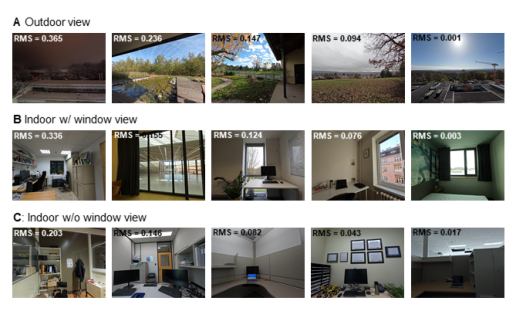

In [236]:
img_contrast_example = mpimg.imread(f'{spatial_paper_dir}//Figure3.png')

plt.imshow(img_contrast_example)
plt.axis('off');  # Turn off axis if you want a cleaner display


# Figure Four

## Figure 4-a (Histogram of RMS contrast by scene category (different colours))

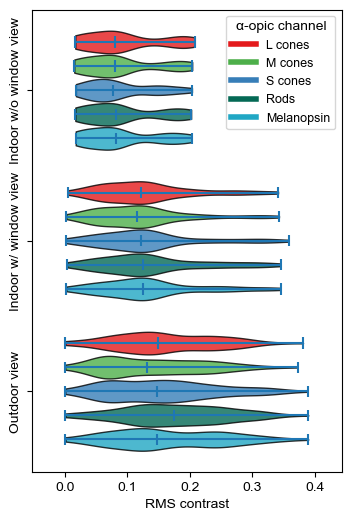

In [73]:
# Filter the columns based on the prefix 'rms'
rms_columns = [
    col for col in merged_wp_jeti_metadata_df.columns if col.startswith('rms')
]

# Create a figure
plt.figure(figsize=(4, 6))


# Map each RMS column to its corresponding color using photoreceptor name
colors = [
    photoreceptor_colors[col.split('_')[2]]  # Extract photoreceptor part and get color
    for col in rms_columns
]

# Prepare data for the violin plots
data_to_plot = []
y_positions = []
color_map = {}  # To store colors for each RMS column based on photoreceptor

# Offset for positioning the violins
offset = 0.16  # Adjust this for spacing
num_metrics = len(rms_columns)

# Loop through each view category
for view_index, view in enumerate(views):
    # Filter data for the current view category
    view_data = merged_wp_jeti_metadata_df[merged_wp_jeti_metadata_df['view'] == view]

    for i, col in enumerate(rms_columns[::-1]):
        # Prepare data for each RMS column
        column_data = view_data[col].dropna().values

        if len(column_data) > 0:  # Only if there's data to plot
            data_to_plot.append(column_data)
            # Position each violin slightly offset from the view index
            y_positions.append(view_index +
                               (i * offset))  # Add offset for each metric

            # Assign color based on photoreceptor
            photoreceptor = col.split('_')[2]  # Extract and lowercase photoreceptor name
            color_map[col] = photoreceptor_colors[photoreceptor]  # Map color

# Create the violin plot with flipped axes
parts = plt.violinplot(data_to_plot,
                       positions=y_positions,
                       showmedians=True,
                       widths=0.15,
                       vert=False)  # Set vert=False for horizontal plot

# Customize the violins
for i, pc in enumerate(parts['bodies']):
    # Get the column for this violin and the corresponding color
    column_name = rms_columns[::-1][i % len(rms_columns)]
    color = color_map[column_name]

    # Set violin properties
    pc.set_facecolor(color)  # Set color from color map
    pc.set_edgecolor('black')  # Set edge color of the violins
    pc.set_alpha(0.8)  # Set transparency

# Calculate the y-tick positions to center them
tick_positions = [
    np.mean([y_positions[i], y_positions[i + len(rms_columns) - 1]])
    for i in range(0, len(y_positions), len(rms_columns))
]

# Adding labels and title
plt.yticks(ticks=tick_positions,
           labels=views,
           rotation=90,
           va='center')
plt.yticks(fontsize=10)
plt.xlabel("RMS contrast",fontsize=10)

# Get current x-axis limits
x_min, x_max = plt.gca().get_xlim()

# Define padding (adjust this value as needed)
padding = (x_max - x_min) * 0.08  # 5% of the current range

# Set new x-axis limits to add space on both sides
plt.xlim(x_min - padding, x_max + padding)

# Create legend using photoreceptor names and their colors
handles = [
    plt.Line2D([0], [0], color=color, lw=4, label=photoreceptor.capitalize())
    for photoreceptor, color in photoreceptor_colors.items()
]
plt.legend(handles=handles,
           title='α-opic channel',
           loc='upper right',
           title_fontsize=10,
           fontsize=9)

plt.savefig(
    f'{spatial_paper_dir}//Violin_plot_rms_contrast_per_view_flip.png',
    dpi=600,
    bbox_inches='tight');


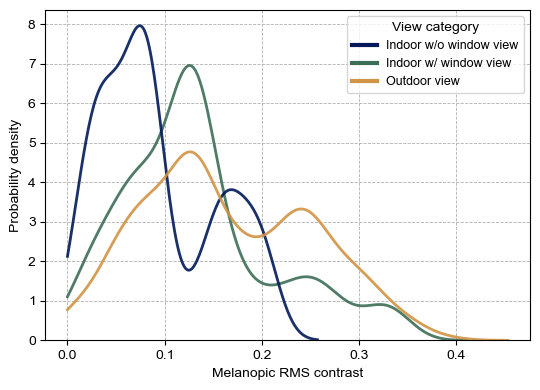

In [217]:
# Density plot for ipRGC

# Initialize the plot
plt.figure(figsize=(5.5, 4))

# Loop through each group in the DataFrame grouped by 'view'
for view, group_df in merged_wp_jeti_metadata_df.groupby('view'):
    sns.kdeplot(data=group_df['rms_contrast_Melanopsin'], 
                label=view, 
                fill=False,
                color=view_color_mapping[view],  
                alpha=0.9,
                bw_adjust=0.8,
                linewidth=2,
                clip=(0, None),  # Clip to prevent negative values
                zorder=2)


custom_handles = [
    plt.Line2D(
        [0], [0],
        color=view_color_mapping[view],
        label=view,
        lw=3  # Set line width to make it thicker,
    )
    for view in ['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view']
]

# Set labels and title
plt.xlabel('Melanopic RMS contrast')
plt.ylabel('Probability density')
#plt.title('Density Plot of Invalid Pixels by View Category')
plt.legend( handles=custom_handles, title='View category', fontsize=9, title_fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.6, zorder = 0)

# Show the plot
plt.tight_layout()
plt.savefig(f'{spatial_paper_dir}//Melanopic_RMS_contrast_KDE_per_view.png',
    dpi=600,
    bbox_inches='tight');

## Figure 4-b (Scatter plot with marginal histograms)
x axis: Melanopic EDL  y axis: RMS contrast

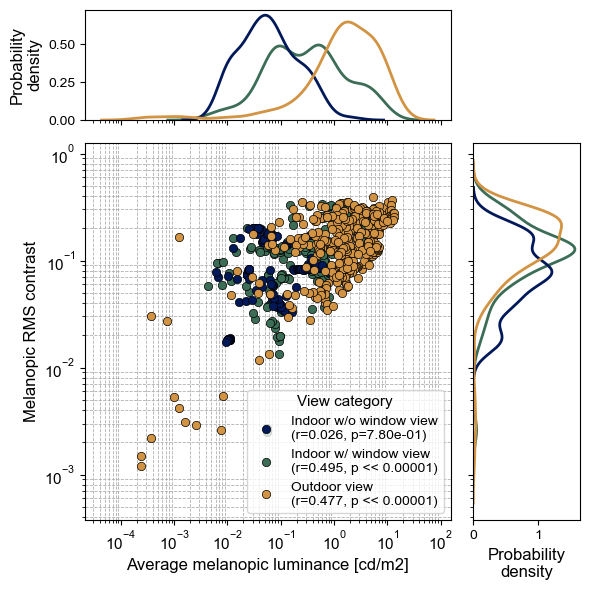

In [218]:
# Create the figure with gridspec for scatter plot and histograms (.replace(0, 1e-3))
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)  # 4x4 grid


# Create the main scatter plot area
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Create the KDE for the x-axis on top
ax_x_kde = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the KDE for the y-axis on the right
ax_y_kde = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

plotted_groups = {}
# Loop through the groups and plot the scatter points
for group, group_df in merged_wp_jeti_metadata_df.groupby('view'):
    
    x_values = group_df['average_luminance_Melanopsin']
    y_values = group_df['rms_contrast_Melanopsin']
     # Calculate the correlation coefficient (r) and p-value
    r, p = stats.pearsonr(x_values, y_values) 
    
    if p < 0.00001:
        label = f"{group}\n(r={r:.3f}, p << 0.00001)"
    else:
        label = f"{group}\n(r={r:.3f}, p={p:.2e})"
    
    # Scatter plot for each group
    ax_main.scatter(x_values, y_values, label=label, color=view_color_mapping[group], edgecolors='black', linewidth=0.5, zorder = 2)
    plotted_groups[group] = label
    # KDE plot on the x-axis
    sns.kdeplot(x=x_values, ax=ax_x_kde, color=view_color_mapping[group], log_scale=True, linewidth=2, label=group)

    # KDE plot on the y-axis, using the `y` argument
    sns.kdeplot(y=y_values, ax=ax_y_kde, color=view_color_mapping[group], log_scale=True, linewidth=2)

# Set log scale for both x and y axes on the main scatter plot
ax_main.set_xscale('log')
ax_main.set_yscale('log')
ax_main.tick_params(axis='x', labelsize=11)  
ax_main.tick_params(axis='y', labelsize=11)

# Set labels for scatter plot
ax_main.set_xlabel('Average melanopic luminance [cd/m2]', fontsize=12)
ax_main.set_ylabel('Melanopic RMS contrast', fontsize=12)
ax_main.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)
# Create a custom legend to enforce the order
custom_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color=view_color_mapping[view],
        label=plotted_groups[view],
        markersize=6,
        linestyle='None',
        markeredgecolor='black',
        markeredgewidth=0.5
    )
    for view in ['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view']]
ax_main.legend( handles = custom_handles, title="View category", loc='lower right', title_fontsize=11, fontsize = 10)

# Hide labels for the KDEs (x and y)
ax_x_kde.set_xlabel('')  # Remove x-axis label for top KDE
ax_y_kde.set_ylabel('')  # Remove y-axis label for right KDE

# Hide the ticks on the marginal KDEs
# ax_x_kde.tick_params(axis='x', which='both', length=0)
# ax_y_kde.tick_params(axis='y', which='both', length=0)

# Hide labels and ticks for the KDEs
plt.setp(ax_x_kde.get_xticklabels(), visible=False)
plt.setp(ax_y_kde.get_yticklabels(), visible=False)
ax_x_kde.set_ylabel('Probability\ndensity', fontsize=12, font = "Arial")
ax_y_kde.set_xlabel('Probability\ndensity', fontsize=12, font = "Arial")

# Ensure log scale is set for the KDEs
ax_x_kde.set_xscale('log')
ax_y_kde.set_yscale('log')
# Add grid to the KDEs for visibility
#ax_x_kde.grid(True, which='minor', linestyle='--', linewidth=0.6)
#ax_y_kde.grid(True, which='minor', linestyle='--', linewidth=0.6)

plt.tight_layout()

plt.savefig(f'{spatial_paper_dir}//RMS_vr_luminance_KDE_logscale_WP.png',
    dpi=600,
    bbox_inches='tight');

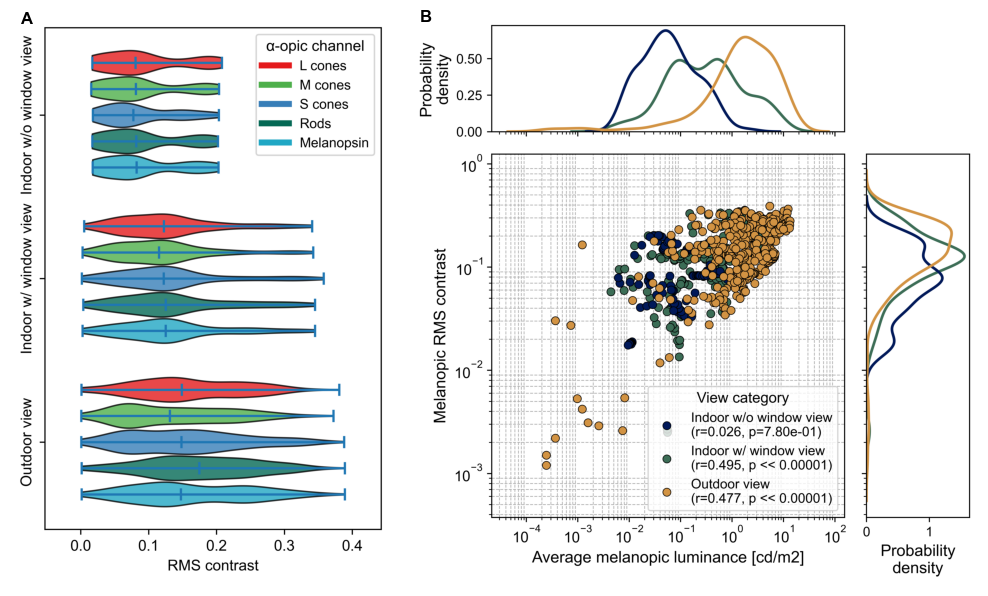

In [222]:
#Figure 4

# Create a figure with the specified size
combined_fig = plt.figure(figsize=(10, 6))

# Define the grid layout: 1 rows and 2 columns with different ratios for each grid cell
gs = gridspec.GridSpec(
    1, 2 , width_ratios=[2, 3]
)


# Load and display the third figure (Image C)
ax1 = combined_fig.add_subplot(gs[0, 0])  # Second row, first column (6*4)
img1 = mpimg.imread(f'{spatial_paper_dir}/Violin_plot_rms_contrast_per_view_flip.png')
ax1.imshow(img1)
ax1.axis('off')  # Hide the axes
ax1.text(0.03, 0.99, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold', color='black')

# Load and display the fourth figure (Image D)
ax2 = combined_fig.add_subplot(gs[0, 1])  # First row, second column (6*6)
img2 = mpimg.imread(f'{spatial_paper_dir}/RMS_vr_luminance_KDE_logscale_WP.png')
ax2.imshow(img2)
ax2.axis('off')  # Hide the axes
ax2.text(0.02, 0.99, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold', color='black')
plt.tight_layout()
# Adjust layout to prevent overlap and fit images tightly
#plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Reduce space between subplots

plt.savefig(f'{spatial_paper_dir}//Figure4.png',
            dpi=600,
            bbox_inches='tight')
plt.savefig(f'{spatial_paper_dir}//Figure4.tiff',
            dpi=600,

            bbox_inches='tight')

# Figure Five 

In [353]:
# Function to calculate and plot α-opics amplitude spectra

def plot_amplitude_spectra_with_fit(npz_file_path, ax=None):
     # Define new key names for the photoreceptor channels
    new_key_names = ["L cones", "M cones", "S cones", "Rods", "Melanopsin"]
    if ax is None:
        ax = plt.gca()
    # Load images from the .npz file
    with np.load(npz_file_path) as npz_file:
        keys = list(npz_file.keys())[:5]  # First five keys
        images = [npz_file[key] for key in keys]
    
    # Iterate over the images and corresponding photoreceptor names
    for image, new_key in zip(images, new_key_names):
        # Compute the amplitude spectrum
        amplitude_spectra = compute_amplitude_spectrum(image)
        
        # Compute the radial frequencies and amplitudes
        radial_frequencies, radial_amplitudes = radial_frequencies_logarithmically_spaced(amplitude_spectra)
        
        # Scatter plot for the amplitude spectrum
        ax.scatter(
            radial_frequencies,
            radial_amplitudes,
            color=photoreceptor_colors[new_key],
            zorder=2
        )
        
        # Perform linear regression in log-log space
        valid_indices = radial_amplitudes > 0  # Ensure valid data
        log_frequencies = np.log10(radial_frequencies[valid_indices])
        log_amplitudes = np.log10(radial_amplitudes[valid_indices])
        
        if len(log_frequencies) > 1:  # Check if regression is possible
            slope, intercept, r_value, p_value, std_err = linregress(log_frequencies, log_amplitudes)
            
            # Generate the regression line
            fitted_amplitudes = (10 ** intercept) * (radial_frequencies ** slope)
            
            # Format the regression line label
            if p_value < 0.00001:
                label = f"{new_key}  r= {r_value:.3f}, p << 0.00001"
            else:
                label = f"{new_key}  r= {r_value:.3f}, p={p_value:.2e}"
             
            # Plot the regression line
            ax.plot(
                radial_frequencies,
                fitted_amplitudes,
                label=label,
                linestyle='--',
                color=photoreceptor_colors[new_key],
                linewidth=1.5,
                zorder=3
            )
        else:
            print(f"Not enough valid data for regression in image {new_key}")
    
    # Set axes to log scale
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Spatial frequency (cycle/image)', fontsize=13)
    ax.set_ylabel('Amplitude', fontsize=13)
    # Set y-axis limits
    ax.set_ylim(top=1e6)  # Ensure the upper limit is 10^6
    # Add legend with thicker lines
    handles, labels = ax.get_legend_handles_labels()
    thicker_handles = [
        plt.Line2D([0], [0], color=handle.get_color(), linestyle='--', lw=2, label=label)
        for handle, label in zip(handles, labels)
    ]
    # Add legend and grid
    ax.legend(handles=thicker_handles, title="α-opic channel", fontsize=10, title_fontsize=11, loc='best')
    ax.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)
    
    # Adjust layout
    plt.tight_layout()

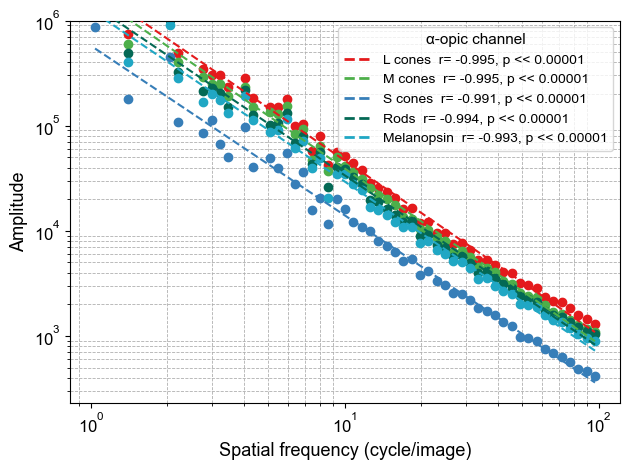

In [354]:
plot_amplitude_spectra_with_fit(file_path_max_slope)

In [355]:
# Function to calculate and plot composite amplitude spectra

def plot_composite_amplitude_spectra(npz_file_path, ax=None):
    composite_key_names = ["L+M+S", "L-M", "S-(L+M)"]
    if ax is None:
        ax = plt.gca()
    # Load images from the .npz file
    with np.load(npz_file_path) as npz_file:
        keys = list(npz_file.keys())[:5]  # First five keys
        images = [npz_file[key] for key in keys]

    # Create the composite arrays
    composite_arrays = {
        "L+M+S": images[0] + images[1] + images[2],  # L + M + S
        "L-M": images[0] - images[1],               # L - M
        "S-(L+M)": images[2] - (images[0] + images[1])  # S - (L + M)
    }

    # Iterate over the composite arrays and their names
    for composite_name, composite_array in composite_arrays.items():
        # Compute the amplitude spectrum
        amplitude_spectrum = compute_amplitude_spectrum(composite_array)
        
        # Compute the radial frequencies and amplitudes
        radial_frequencies, radial_amplitudes = radial_frequencies_logarithmically_spaced(amplitude_spectrum)
        
        # Scatter plot for the amplitude spectrum
        ax.scatter(
            radial_frequencies,
            radial_amplitudes,
            zorder=2
        )
        
        # Perform linear regression in log-log space
        valid_indices = radial_amplitudes > 0  # Ensure valid data
        log_frequencies = np.log10(radial_frequencies[valid_indices])
        log_amplitudes = np.log10(radial_amplitudes[valid_indices])
        
        if len(log_frequencies) > 1:  # Check if regression is possible
            slope, intercept, r_value, p_value, std_err = linregress(log_frequencies, log_amplitudes)
            
            # Generate the regression line
            fitted_amplitudes = (10 ** intercept) * (radial_frequencies ** slope)
            
            # Format the regression line label
            if p_value < 0.00001:
                label = f"{composite_name} r= {r_value:.3f}, p << 0.00001"
            else:
                label = f"{composite_name} r= {r_value:.3f}, p={p_value:.2e}"
            
            # Plot the regression line
            ax.plot(
                radial_frequencies,
                fitted_amplitudes,
                label=label,
                linestyle='--',
                linewidth=1.5,
                zorder=3
            )
        else:
            print(f"Not enough valid data for regression in composite array {composite_name}")
    
    # Set axes to log scale
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Spatial frequency (cycle/image)', fontsize=13)
    ax.set_ylabel('Amplitude', fontsize=13)
    # Set y-axis limits
    ax.set_ylim(top=1e6)  # Ensure the upper limit is 10^6
    # Add legend with thicker lines
    handles, labels = ax.get_legend_handles_labels()
    thicker_handles = [
        plt.Line2D([0], [0], color=handle.get_color(), linestyle='--', lw=2, label=label)
        for handle, label in zip(handles, labels)
    ]
    # Add legend and grid
    ax.legend(handles=thicker_handles, title="Composite channel", fontsize=10, title_fontsize=11, loc='best')
    ax.grid(True, which='minor', linestyle='--', linewidth=0.6, zorder=0)
    
    # Set the title
    #ax.set_title("Composite Amplitude Spectra and Regression Lines", fontsize=14)
    
    # Adjust layout
    plt.tight_layout()

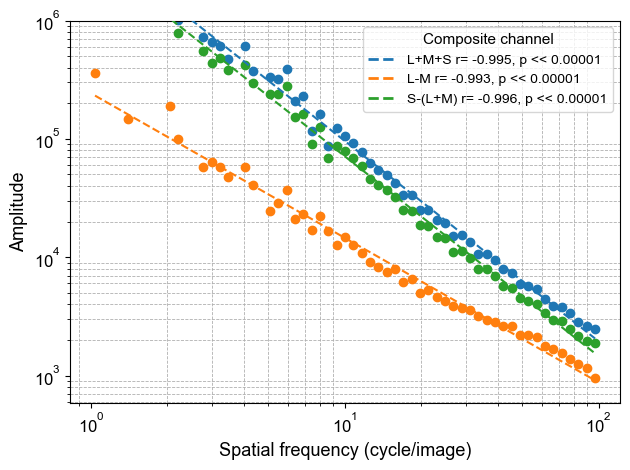

In [356]:
plot_composite_amplitude_spectra(file_path_max_slope)

In [357]:
# Function to plot amplitude spectra

def plot_combined_photoreceptor_composite_spectra(image_path, npz_file_path):
    # Create the figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

    # First column: Plot the image
    img = plt.imread(image_path)
    axes[0].imshow(img)
    axes[0].set_anchor('S')  # Align the image to the bottom of the axes 
    axes[0].axis("off")  # Hide axes for the image
    
    # Second column: Plot photoreceptor amplitude spectra
    plot_amplitude_spectra_with_fit(npz_file_path, axes[1])  # Call the first function
   

    # Third column: Plot composite amplitude spectra
    plt.sca(axes[2])  # Set the current axis to the third subplot
    plot_composite_amplitude_spectra(npz_file_path, axes[2])  # Call the second function
    

    # Adjust layout
    plt.tight_layout()

In [349]:
#General Min Slope: -0.20099651727459292 at timestamp 20230622T2130
image_path_min_slope = f'{root_dir}//derivatives//gopro_derivatives//1016_20230622//1016_20230622T2130/gopro10photo_undistorted_20230622T2130.JPG'
file_path_min_slope = f'{root_dir}//derivatives//wp_derivatives//1016_20230622//1016_20230622T2130/wp690_20230622T2130.npz'

#General Max Slope: -1.7401402144449543 at timestamp 20230619T0900
#Second Max Slope: -1.63 at timestamp 20240315T1800
image_path_max_slope = f'{root_dir}//derivatives//gopro_derivatives//1045_20240315//1045_20240315T1800/gopro10photo_undistorted_20240315T1800.JPG'
file_path_max_slope = f'{root_dir}//derivatives//wp_derivatives//1045_20240315//1045_20240315T1800/wp690_20240315T1800.npz'

## Figure 5-a (Example of a low-slope scene – image + amplitude spectrum + fit)

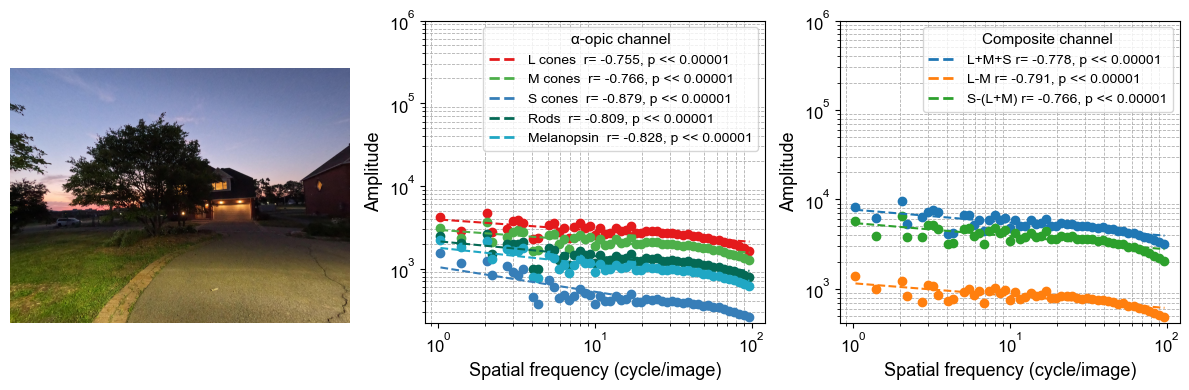

In [358]:
plot_combined_photoreceptor_composite_spectra(image_path_min_slope, file_path_min_slope )
#plt.tight_layout()
plt.savefig(f'{spatial_paper_dir}//Min_slope.png',
            dpi=600,
            bbox_inches='tight')

## Figure 5-b (Example of a high-slope scene – image + amplitude spectrum + fit)

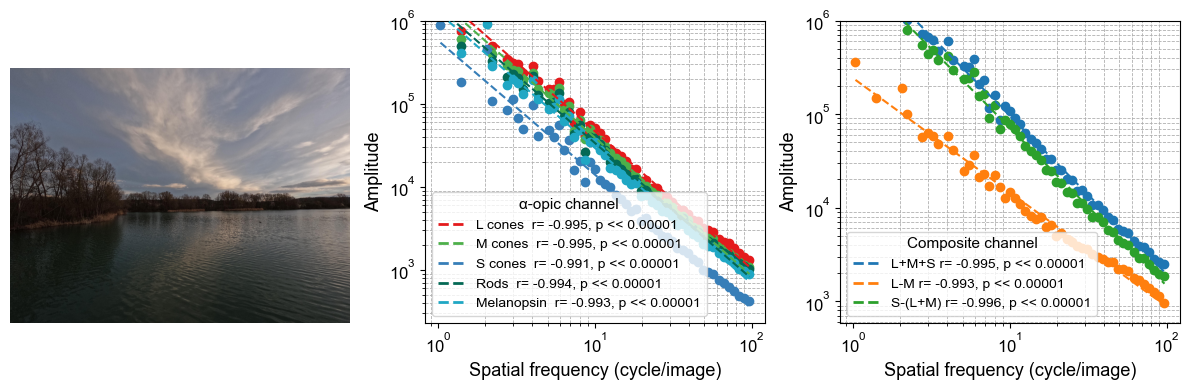

In [359]:
plot_combined_photoreceptor_composite_spectra(image_path_max_slope, file_path_max_slope )
#plt.tight_layout()
plt.savefig(f'{spatial_paper_dir}//Max_slope.png',
            dpi=600,
            bbox_inches='tight')

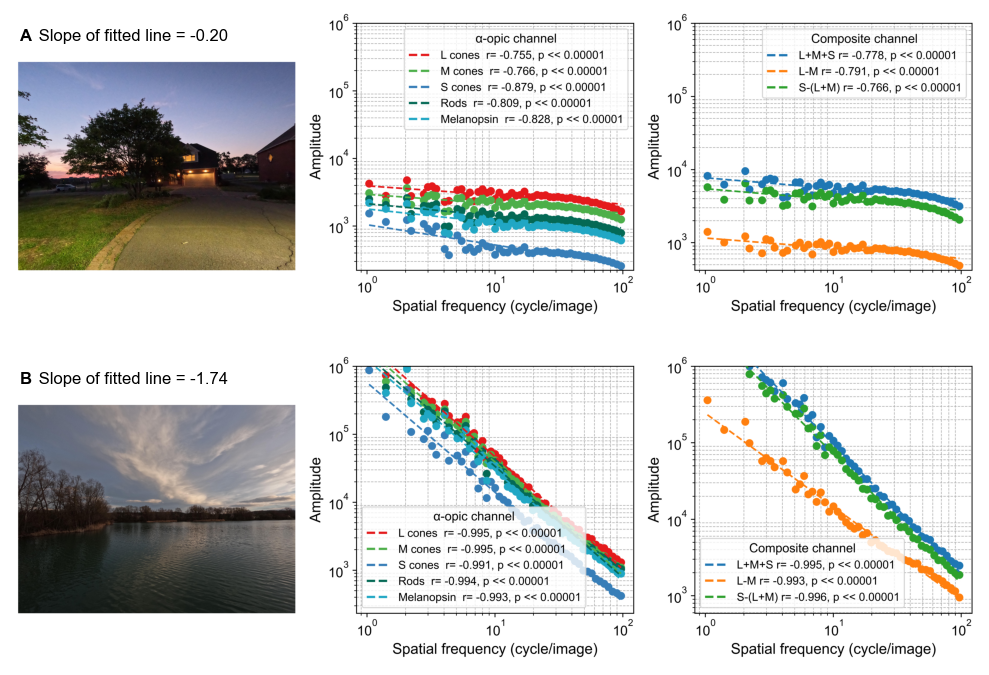

In [360]:
#Figure 5

# Create a figure with the specified size
combined_fig = plt.figure(figsize=(10, 7))

# Define the grid layout: 2 rows and 1 columns
gs = gridspec.GridSpec(2, 1)

# Load and display the third figure
ax1 = combined_fig.add_subplot(gs[0, 0])
img1 = mpimg.imread(f'{spatial_paper_dir}//min_slope.png')
ax1.imshow(img1)
ax1.axis('off')  # Hide the axes
ax1.text(0.01,
         0.9,
         'A',
         transform=ax1.transAxes,
         fontsize=12,
         fontweight='bold',
         color='black')

ax1.text(0.025,
         0.9,
         ' Slope of fitted line = -0.20',
         transform=ax1.transAxes,
         fontsize=12,
         fontweight='normal',
         color='black')

# Load and display the fourth figure
ax2 = combined_fig.add_subplot(gs[1, 0])
img2 = mpimg.imread(f'{spatial_paper_dir}//max_slope.png')
ax2.imshow(img2)
ax2.axis('off')  # Hide the axes
ax2.text(0.01,
         0.9,
         'B',
         transform=ax2.transAxes,
         fontsize=12,
         fontweight='bold',
         color='black')
ax2.text(0.025,
         0.9,
         ' Slope of fitted line = -1.74',
         transform=ax2.transAxes,
         fontsize=12,
         fontweight='normal',
         color='black')

plt.tight_layout()
# Adjust layout to prevent overlap and fit images tightly
#plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Reduce space between subplots

plt.savefig(f'{spatial_paper_dir}//Figure5.png', dpi=600, bbox_inches='tight')
plt.savefig(f'{spatial_paper_dir}//Figure5.tiff', dpi=600, bbox_inches='tight')

# Figure 6 (Histogram of slopes for all scenes based on view categories)

In [237]:
amplitude_spectra_regression_df = pd.read_csv(
    f'{spatial_paper_dir}//amplitude_spectra_regression_view_df.csv',
    header=0
    )
amplitude_spectra_regression_df.head()

slope_Outdoor view  r_value_Outdoor view  p_value_Outdoor view  \
0           -1.482937             -0.987556          3.181121e-40   
1           -1.430684             -0.980685          1.128222e-35   
2           -1.446821             -0.981908          2.378185e-36   
3           -1.511422             -0.983934          1.406927e-37   
4           -1.552161             -0.984029          1.221771e-37   

   std_err_Outdoor view timestamp_Outdoor view  slope_Indoor w/ window view  \
0              0.034086          20230208T0800                    -1.123225   
1              0.041186          20230208T0900                    -1.149777   
2              0.040272          20230208T0930                    -1.176681   
3              0.039584          20230208T1000                    -1.153312   
4              0.040528          20230208T1030                    -1.100609   

   r_value_Indoor w/ window view  p_value_Indoor w/ window view  \
0                      -0.987859                   1.769766e-40   
1                      -0.985653                   9.478916e-39   
2                      -0.987464                   3.793797e-40   
3                      -0.984965                   2.898748e-38   
4                      -0.985813                   7.264637e-39   

   std_err_Indoor w/ window view timestamp_Indoor w/ window view  \
0                       0.025496                   20230310T0800   
1                       0.028418                   20230310T0830   
2                       0.027148                   20230310T0900   
3                       0.029197                   20230310T0930   
4                       0.027048                   20230310T1000   

   slope_Indoor w/o window view  r_value_Indoor w/o window view  \
0                     -1.539778                       -0.987227   
1                     -1.551757                       -0.986582   
2                     -1.542314                       -0.985124   
3                     -1.531387                       -0.984098   
4                     -1.546493                       -0.985594   

   p_value_Indoor w/o window view  std_err_Indoor w/o window view  \
0                    5.939593e-40                        0.035867   
1                    1.922580e-39                        0.037066   
2                    2.248892e-38                        0.038833   
3                    1.101605e-37                        0.039896   
4                    1.045669e-38                        0.038304   

  timestamp_Indoor w/o window view  
0                    20230404T1030  
1                    20230404T1100  
2                    20230404T1130  
3                    20230404T1200  
4                    20230404T1230

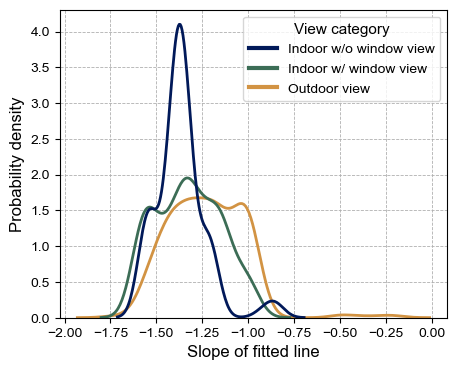

In [241]:
#Figure 6

# Extract the columns related to slopes for each view category
slope_columns = [col for col in amplitude_spectra_regression_df.columns if col.startswith('slope')]
view_categories = [col.split('_')[1] for col in slope_columns]  # Extract view categories from column names

# Create the plot
plt.figure(figsize=(5, 4))

# Iterate over the slope columns and plot KDE for each view category
for slope_column in slope_columns:
    view_category = slope_column.split('_')[1]  # Get the view category (Outdoor, Indoor, etc.)
    slopes = amplitude_spectra_regression_df[slope_column]  # Extract slope values for the view category
    sns.kdeplot(slopes, label=view_category, color=view_color_mapping[view_category], linewidth=2)

# Customize the plot
plt.xlabel('Slope of fitted line', fontsize=12)
plt.ylabel('Probability density', fontsize=12)

# Create legend with forced order
handles = [
    plt.Line2D([0], [0], color=view_color_mapping[view], lw=3, label=view)
    for view in ['Indoor w/o window view', 'Indoor w/ window view', 'Outdoor view']
]

plt.legend(handles=handles, title='View category', loc='upper right', fontsize=10, title_fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.savefig(f'{spatial_paper_dir}//Figure6.png',
            dpi=600,
            bbox_inches='tight')
plt.savefig(f'{spatial_paper_dir}//Figure6.tiff',
            dpi=600,
            bbox_inches='tight')

# Supplementary plots

Other Alph-opic chaneels invalid pixels plots

# Codes to use for plots

In [ ]:
#Suplementary 

# Total number of pixels per image
total_pixels = 9188256

# List of column names that you want to plot
columns_to_plot = ['lcone Inf', 'mcone Inf', 'scone Inf', 'rhodopic Inf', 'iprgc Inf']

# Calculate the percentage of invalid pixels for each specified column
for col in columns_to_plot:
    merged_wp_jeti_metadata_df[f'{col}_percentage'] = (merged_wp_jeti_metadata_df[col] / total_pixels) * 100

# Prepare data for the histogram
data_to_plot = [merged_wp_jeti_metadata_df[f'{col}_percentage'] for col in columns_to_plot]

# Define the number of bins for the histogram
bins = np.linspace(0, 100, num=11)  # 10 bins from 0 to 100%
num_bins = len(bins) - 1  # Number of bins

# Set up the bar width and the number of columns
num_columns = len(columns_to_plot)
bar_width = 0.15  # Adjusted bar width for spacing

# Initialize a list to store frequency counts for each column
frequencies = np.zeros((num_bins, num_columns))

# Calculate the frequency counts for each column
for i in range(num_columns):
    frequencies[:, i], _ = np.histogram(data_to_plot[i], bins)

# Initialize x_positions for bar placement
x_positions = np.arange(num_bins)

# Plot each set of frequencies
plt.figure(figsize=(10, 6))
for i in range(num_columns):
    plt.bar(x_positions + (i) * bar_width, frequencies[:, i],  # Adjust the position
            width=bar_width, alpha=0.9,
            label=columns_to_plot[i],
            edgecolor='black',  align='center',
            color=cmap(i / num_columns), zorder =2)

# Customize the plot
#plt.title('Histogram of Percentage of Invalid Pixels for Alpha-opic Images')
plt.xlabel('Percentage of Invalid Pixels')
plt.ylabel('Frequency')
plt.xticks(x_positions + (num_columns - 1) * bar_width / 2, [f'{int(pos)}%' for pos in bins[:-1]]) 

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, zorder = 0);

## calculating Alpha-opics EDI with the Luxpy package

In [ ]:
df = pd.read_excel(r'\\kfs\tscn-dropbox\scenes\data\raw\1003_20230224\1003_20230224T0800\jeti1511_20230224T0800.xlsx', header = 0, skiprows = 324)
df = df.iloc[:401] 

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy(dtype=float)
#lx.toolboxes.photbiochem.spd_to_aopicEDI(data_array,
#                                           E=None,
 #                                           Q=None,
  #                                          cieobs='1931_2',
   #                                         sid_units='W/m2',
    #                                        actionspectra='CIE-S026',
     #                                       ref='D65',
      #                                      out='a_edi')

### Chromaticity for all 'view'

In [ ]:
# Chromaticity plot for all "views" (Jeti)

# Create a figure and axis
fig, ax = plt.subplots( figsize=(6, 10))

# Iterate through each group and plot scatter
for i, (group, group_df) in enumerate(merged_jeti_metadata_df.groupby('view')):
    x_values = group_df['x']
    y_values = group_df['y']
    ax.scatter(x_values, y_values, label=group, color=colors[i], edgecolors='black', linewidth=0.5, zorder=2)

# Customize the axis
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Chromaticity')
ax.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax.legend(loc='lower right')
# Adjust y-axis ticks and labels
y_ticks = ax.get_yticks()

# Choose 5 evenly spaced ticks from the existing ticks
desired_y_ticks = plt.MaxNLocator(5).tick_values(y_ticks.min(), y_ticks.max())

# Set new ticks and labels for y-axis
ax.set_yticks(desired_y_ticks)
ax.set_yticklabels([f'{tick:.2f}' for tick in desired_y_ticks]) 
# Adjust x-axis ticks and labels to be similar to the y-axis
x_ticks = ax.get_xticks()
desired_x_ticks = plt.MaxNLocator(5).tick_values(x_ticks.min(), x_ticks.max())
ax.set_xticks(desired_x_ticks)
ax.set_xticklabels([f'{tick:.2f}' for tick in desired_x_ticks])

# Additional plots

#colour.plotting.plot_planckian_locus_in_chromaticity_diagram_CIE1931(illuminants=['A'], axes=ax, alpha=0.5, zorder = 1 )
colour.plotting.plot_planckian_locus_in_chromaticity_diagram_CIE1931(illuminants=['D65'], axes=ax, alpha=0.5, zorder = 1 );

#colour.plotting.temperature.plot_planckian_locus(planckian_locus_colours='RGB', method='CIE 1931', axes=ax )
#colour.plotting.temperature.plot_daylight_locus( daylight_locus_colours='RGB',method='CIE 1931', axes=ax)

plt.savefig('results/spatial_analysis/paper-plots/All_view_chromaticity_diagram_jeti.jpeg', dpi= 1200)
plt.savefig('results/spatial_analysis/paper-plots/All_view_chromaticity_diagram_jeti.svg', dpi= 1200);


In [ ]:
# corrrelation within an image ave over three categories, change the color
# Create a mask for the upper triangle (True for the lower triangle)
mask = np.tril(np.ones_like(corr_matrix_wp_average, dtype=bool), k=0)

# Get the tick labels (last part of the variable names)
tick_labels = [name.split('_')[-1] for name in corr_matrix_wp_average.columns]

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix_wp_average, annot=True, fmt=".4f", cmap= cmap_blues, vmin=0.5, vmax=1, 
            linewidths=0.7, linecolor='white', mask=mask, xticklabels=tick_labels, yticklabels=tick_labels, cbar_kws={'aspect': 30, 'shrink': 1}, square=True)



plt.gca().spines[:].set_visible(True)
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(rotation=45, fontsize = 10)
plt.tight_layout()
plt.title("Correlation Matrix of Average Radiances", pad=20);

In [ ]:
# Plot illumnance ver mel-EDI for all days in one plot (Jeti)

fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(4, 4)  # 4x4 grid


# Define the number of bins
num_bins = 20

# Determine the global min and max for both axes
x_min = merged_jeti_metadata_df['Illuminance [lx] (CIE1931 2°)'].min()
x_max = merged_jeti_metadata_df['Illuminance [lx] (CIE1931 2°)'].max()
y_min = merged_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].min()
y_max = merged_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].max()

# Create fixed bin edges for both axes
bins_x = np.linspace(x_min, x_max, num_bins + 1)
bins_y = np.linspace(y_min, y_max, num_bins + 1)

# Create the figure with gridspec for scatter plot and histograms
fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Create the main scatter plot area
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Create the histogram for the x-axis on top
ax_x_hist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the histogram for the y-axis on the right
ax_y_hist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Create arrays to hold counts for the stacked histograms
counts_x = np.zeros(num_bins)
counts_y = np.zeros(num_bins)

# Loop through the groups and plot the scatter points
for i, (group, group_df) in enumerate(merged_jeti_metadata_df.groupby('view')):
    
    x_values = group_df['Illuminance [lx] (CIE1931 2°)']
    y_values = group_df['X v,mel,D65 (MEDI) [lx]']
    
    # Scatter plot for each group
    ax_main.scatter(x_values, y_values, label=group, color=cmap_colors[i], edgecolors='black', linewidth=0.5, zorder = 2)

    # Plot histograms on the marginals
    # Calculate histogram for x-axis
    hist_x, _ = np.histogram(x_values, bins=bins_x)
    ax_x_hist.bar(bins_x[:-1], hist_x, width=np.diff(bins_x), 
                  bottom=counts_x, color=cmap_colors[i], label=group, edgecolor='black', zorder = 2)
    counts_x += hist_x  # Update cumulative counts for x

    # Calculate histogram for y-axis
    hist_y, _ = np.histogram(y_values, bins=bins_y)
    ax_y_hist.barh(bins_y[:-1], hist_y, height=np.diff(bins_y), 
                    left=counts_y, color=cmap_colors[i], label=group, edgecolor='black', zorder = 2)
    counts_y += hist_y  # Update cumulative counts for y

# Set labels for scatter plot
ax_main.set_xlabel('Photopic illuminance [lx]')
ax_main.set_ylabel('mel-EDI [lx]')
ax_main.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax_main.legend(title='View categories')

# Hide labels and ticks for the histograms
plt.setp(ax_x_hist.get_xticklabels(), visible=False)
plt.setp(ax_y_hist.get_yticklabels(), visible=False)

# Add grid to the histograms for visibility
ax_x_hist.grid(True, linestyle='--', linewidth=0.5, zorder = 0)
ax_y_hist.grid(True, linestyle='--', linewidth=0.5, zorder = 0)
plt.tight_layout()
plt.savefig('results/spatial_analysis/paper-plots/mel-EDI_vr_Illuminance_histogram_jeti.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/mel-EDI_vr_Illuminance_histogram_jeti.svg', dpi= 1200);


In [ ]:
# Create the figure with gridspec for scatter plot and histograms
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Define the number of bins
num_bins = 20

# Determine the global min and max for both axes
x_min = merged_jeti_metadata_df['Illuminance [lx] (CIE1931 2°)'].min()
x_max = merged_jeti_metadata_df['Illuminance [lx] (CIE1931 2°)'].max()
y_min = merged_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].min()
y_max = merged_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].max()

# Set a small positive value to avoid log(0)
x_min = max(x_min, 1e-1)
y_min = max(y_min, 1e-1)

# Create fixed bin edges for both axes
bins_x = np.logspace(np.log10(x_min), np.log10(x_max), num_bins + 1)
bins_y = np.logspace(np.log10(y_min), np.log10(y_max), num_bins + 1)

# Create the figure with gridspec for scatter plot and histograms
fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Create the main scatter plot area
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Create the histogram for the x-axis on top
ax_x_hist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the histogram for the y-axis on the right
ax_y_hist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Create arrays to hold counts for the stacked histograms
counts_x = np.zeros(num_bins)
counts_y = np.zeros(num_bins)

# Loop through the groups and plot the scatter points
for i, (group, group_df) in enumerate(merged_wp_jeti_metadata_df.groupby('view')):
    
    x_values = group_df['Illuminance [lx] (CIE1931 2°)']
    y_values = group_df['X v,mel,D65 (MEDI) [lx]']
    
    # Scatter plot for each group with log scaling
    ax_main.scatter(x_values, y_values, label=group, color=cmap_colors[i], edgecolors='black', linewidth=0.5, zorder = 2)

    # Plot histograms on the marginals
    # Calculate histogram for x-axis
    hist_x, _ = np.histogram(x_values, bins=bins_x)
    ax_x_hist.bar(bins_x[:-1], hist_x, width=np.diff(bins_x) * 0.7,  # Reduce width to avoid overlap
                  bottom=counts_x, color=cmap_colors[i], alpha=0.9, 
                  edgecolor='black', linewidth=1, label=group, zorder = 2)
    counts_x += hist_x  # Update cumulative counts for x

    # Calculate histogram for y-axis
    hist_y, _ = np.histogram(y_values, bins=bins_y)
    ax_y_hist.barh(bins_y[:-1], hist_y, height=np.diff(bins_y) * 0.7,  # Reduce height to avoid overlap
                    left=counts_y, color=cmap_colors[i], alpha=0.9, 
                    edgecolor='black', linewidth=1, label=group, zorder = 2)
    counts_y += hist_y  # Update cumulative counts for y

# Set log scale for both x and y axes on the main scatter plot
ax_main.set_xscale('log')
ax_main.set_yscale('log')

# Set labels for scatter plot
ax_main.set_xlabel('Photopic illuminance [lx]')
ax_main.set_ylabel('mel-EDI [lx]')
ax_main.grid(True, which='minor', linestyle='--', linewidth=0.5, zorder=0)
ax_main.legend(title="View categories")

# Hide labels and ticks for the histograms
plt.setp(ax_x_hist.get_xticklabels(), visible=False)
plt.setp(ax_y_hist.get_yticklabels(), visible=False)

# Add grid to the histograms for visibility
ax_x_hist.grid(True, linestyle='--', linewidth=0.5)
ax_y_hist.grid(True, linestyle='--', linewidth=0.5)

# Set log scale for marginal histograms
ax_x_hist.set_xscale('log')
ax_y_hist.set_yscale('log')

plt.tight_layout()
plt.savefig('results/spatial_analysis/paper-plots/mel-EDI_vr_Illuminance_histogram_logscale_jeti.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/mel-EDI_vr_Illuminance_histogram_logscale_jeti.svg', dpi= 1200);

In [ ]:
# Plot illumnance ver mel-EDI for all days in one plot (Jeti) 

fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(4, 4)  # 4x4 grid


# Define the number of bins
num_bins = 20

# Determine the global min and max for both axes
x_min = merged_wp_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].min()
x_max = merged_wp_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].max()
y_min = merged_wp_jeti_metadata_df['average_radiances_iprgc'].min()
y_max = merged_wp_jeti_metadata_df['average_radiances_iprgc'].max()

# Create fixed bin edges for both axes
bins_x = np.linspace(x_min, x_max, num_bins + 1)
bins_y = np.linspace(y_min, y_max, num_bins + 1)

# Create the figure with gridspec for scatter plot and histograms
fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Create the main scatter plot area
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Create the histogram for the x-axis on top
ax_x_hist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the histogram for the y-axis on the right
ax_y_hist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Create arrays to hold counts for the stacked histograms
counts_x = np.zeros(num_bins)
counts_y = np.zeros(num_bins)

# Loop through the groups and plot the scatter points
for i, (group, group_df) in enumerate(merged_wp_jeti_metadata_df.groupby('view')):
    
    x_values = group_df['X v,mel,D65 (MEDI) [lx]']
    y_values = group_df['average_radiances_iprgc']
    
    # Scatter plot for each group
    ax_main.scatter(x_values, y_values, label=group, color=cmap_colors[i], edgecolors='black', linewidth=0.5)

    # Plot histograms on the marginals
    # Calculate histogram for x-axis
    hist_x, _ = np.histogram(x_values, bins=bins_x)
    ax_x_hist.bar(bins_x[:-1], hist_x, width=np.diff(bins_x), 
                  bottom=counts_x, color=cmap_colors[i], label=group, edgecolor='black', zorder = 2)
    counts_x += hist_x  # Update cumulative counts for x

    # Calculate histogram for y-axis
    hist_y, _ = np.histogram(y_values, bins=bins_y)
    ax_y_hist.barh(bins_y[:-1], hist_y, height=np.diff(bins_y), 
                    left=counts_y, color=cmap_colors[i], label=group, edgecolor='black', zorder = 2)
    counts_y += hist_y  # Update cumulative counts for y

# Set labels for scatter plot
ax_main.set_xlabel('Melanopic equivalent daylight illuminance [lx]_Jeti')
ax_main.set_ylabel('Mean melanopic radiance [W/sqm]_WP')
ax_main.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax_main.legend(title="View categories")

# Hide labels and ticks for the histograms
plt.setp(ax_x_hist.get_xticklabels(), visible=False)
plt.setp(ax_y_hist.get_yticklabels(), visible=False)

# Add grid to the histograms for visibility
ax_x_hist.grid(True, linestyle='--', linewidth=0.5)
ax_y_hist.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('results/spatial_analysis/paper-plots/WP_vr_Jeti_histogram.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/WP_vr_Jeti_histogram.svg', dpi= 1200);


In [ ]:
# Plot with irradiance

# Create the figure with gridspec for scatter plot and histograms
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Define the number of bins
num_bins = 20

# Determine the global min and max for both axes
x_min = merged_wp_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].min()
x_max = merged_wp_jeti_metadata_df['X v,mel,D65 (MEDI) [lx]'].max()
y_min = merged_wp_jeti_metadata_df['average_radiances_iprgc'].min()
y_max = merged_wp_jeti_metadata_df['average_radiances_iprgc'].max()

# Set a small positive value to avoid log(0)
x_min = max(x_min, 1e-1)
y_min = max(y_min, 1e-1)

# Create fixed bin edges for both axes
bins_x = np.logspace(np.log10(x_min), np.log10(x_max), num_bins + 1)
bins_y = np.logspace(np.log10(y_min), np.log10(y_max), num_bins + 1)

# Create the figure with gridspec for scatter plot and histograms
fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(4, 4)  # 4x4 grid

# Create the main scatter plot area
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Create the histogram for the x-axis on top
ax_x_hist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

# Create the histogram for the y-axis on the right
ax_y_hist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Create arrays to hold counts for the stacked histograms
counts_x = np.zeros(num_bins)
counts_y = np.zeros(num_bins)

# Loop through the groups and plot the scatter points
for i, (group, group_df) in enumerate(merged_wp_jeti_metadata_df.groupby('view')):
    
    x_values = group_df['X v,mel,D65 (MEDI) [lx]']
    y_values = group_df['average_radiances_iprgc']
    
    # Scatter plot for each group with log scaling
    ax_main.scatter(x_values, y_values, label=group, color=cmap_colors[i], edgecolors='black', linewidth=0.5, zorder = 2)

    # Plot histograms on the marginals
    # Calculate histogram for x-axis
    hist_x, _ = np.histogram(x_values, bins=bins_x)
    ax_x_hist.bar(bins_x[:-1], hist_x, width=np.diff(bins_x) * 0.65,  # Reduce width to avoid overlap
                  bottom=counts_x, color=cmap_colors[i], alpha=0.9, 
                  edgecolor='black', linewidth=1, label=group, zorder = 2)
    counts_x += hist_x  # Update cumulative counts for x

    # Calculate histogram for y-axis
    hist_y, _ = np.histogram(y_values, bins=bins_y)
    ax_y_hist.barh(bins_y[:-1], hist_y, height=np.diff(bins_y) * 0.8,  # Reduce height to avoid overlap
                    left=counts_y, color=cmap_colors[i], alpha=0.9, 
                    edgecolor='black', linewidth=1, label=group, zorder = 2)
    counts_y += hist_y  # Update cumulative counts for y

# Set log scale for both x and y axes on the main scatter plot
ax_main.set_xscale('log')
ax_main.set_yscale('log')

# Set labels for scatter plot
ax_main.set_xlabel('Melanopic equivalent daylight illuminance [lx]')
ax_main.set_ylabel('Average melanopic radiances [W/sqm]')
ax_main.grid(True, which='minor', linestyle='--', linewidth=0.5, zorder=0)
ax_main.legend(title="View categories")

# Hide labels and ticks for the histograms
plt.setp(ax_x_hist.get_xticklabels(), visible=False)
plt.setp(ax_y_hist.get_yticklabels(), visible=False)

# Add grid to the histograms for visibility
ax_x_hist.grid(True, linestyle='--', linewidth=0.5)
ax_y_hist.grid(True, linestyle='--', linewidth=0.5)

# Set log scale for marginal histograms
ax_x_hist.set_xscale('log')
ax_y_hist.set_yscale('log')

plt.tight_layout()

plt.savefig('results/spatial_analysis/paper-plots/WP_vr_Jeti_histogram_logscale.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/WP_vr_Jeti_histogram_logscale.svg', dpi= 1200);

In [ ]:

# Filter the columns based on the prefix 'rms'
average_columns = [col for col in merged_wp_jeti_metadata_df.columns if col.startswith('average')]

# Create a figure
plt.figure(figsize=(6, 12))

# Get unique view categories
view_categories = merged_wp_jeti_metadata_df['view'].unique()

# Map each RMS column to its corresponding color using photoreceptor name
colors = [
    photoreceptor_colors[col.split('_')[2]]  # Extract photoreceptor part and get color
    for col in average_columns
]

# Prepare data for the violin plots
data_to_plot = []
y_positions = []
color_map = {}  # To store colors for each RMS column based on photoreceptor

# Offset for positioning the violins
offset = 0.16  # Adjust this for spacing
num_metrics = len(average_columns)

# Loop through each view category
for view_index, view in enumerate(view_categories):
    # Filter data for the current view category
    view_data = merged_wp_jeti_metadata_df[merged_wp_jeti_metadata_df['view'] == view]
    
    for i, col in enumerate(average_columns):
        # Prepare data for each RMS column
        column_data = view_data[col].dropna().values
        
        if len(column_data) > 0:  # Only if there's data to plot
            data_to_plot.append(column_data)
            # Position each violin slightly offset from the view index
            y_positions.append(view_index + (i * offset))  # Add offset for each metric
            
            # Assign color based on photoreceptor
            photoreceptor = col.split('_')[2]  # Extract and lowercase photoreceptor name
            color_map[col] = photoreceptor_colors[photoreceptor]  # Map color

# Create the violin plot with flipped axes
parts = plt.violinplot(data_to_plot, positions=y_positions, showmedians=True, widths=0.15, vert=False)  # Set vert=False for horizontal plot

# Customize the violins
for i, pc in enumerate(parts['bodies']):
    # Get the column for this violin and the corresponding color
    column_name = average_columns[i % len(average_columns)]
    color = color_map[column_name]
    
    # Set violin properties
    pc.set_facecolor(color)        # Set color from color map
    pc.set_edgecolor('black')      # Set edge color of the violins
    pc.set_alpha(0.7)              # Set transparency

# Calculate the y-tick positions to center them
tick_positions = [np.mean([y_positions[i], y_positions[i + len(average_columns) - 1]]) for i in range(0, len(y_positions), len(average_columns))]

# Adding labels and title
plt.yticks(ticks=tick_positions, labels=view_categories, rotation = 45)
plt.xscale('log')
plt.xlabel("Average radiances Values")
plt.ylabel("View")
plt.title("Horizontal Violin Plot of Average radiances Values by View in log scale")

# Create legend using photoreceptor names and their colors
handles = [plt.Line2D([0], [0], color=color, lw=4, label=photoreceptor.capitalize()) 
           for photoreceptor, color in photoreceptor_colors.items()]
plt.legend(handles=handles, title='Photoreceptors', loc='upper left')


plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_average_radiances_logscale_view_categories.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_average_radiances_logscale_view_categories.svg', dpi= 1200);

In [ ]:
# Identify RMS columns
rms_columns = [col for col in view_stats.columns if col.startswith('rms_contrast')]
rms_means = [col for col in rms_columns if col.endswith('mean')]
rms_stds = [col for col in rms_columns if col.endswith('std')]

# Set up bar width and positions
bar_width = 0.15
indices = np.arange(len(view_stats['view']))

# Map each RMS mean column to its corresponding color using photoreceptor name
colors = [
    photoreceptor_colors[rms_mean.split('_')[2]]  # Extract photoreceptor part and get color
    for rms_mean in rms_means
]

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot each RMS metric with custom colors
for i, (rms_mean, color) in enumerate(zip(rms_means, colors)):
    # Calculate the position for this bar group
    bar_positions = indices + (i * bar_width)
    
    # Extract means and stds for the current RMS metric
    means = view_stats[rms_mean]
    stds = view_stats[rms_stds[i]]
    
    # Create bar plot with error bars
    plt.bar(bar_positions, means, yerr=stds, width=bar_width, capsize=5, color=color, label=rms_mean.split('_mean')[0], alpha=0.7)

# Adding labels and title
plt.xlabel("View")
plt.ylabel("Mean  of rms contrast")
plt.title("Mean and Standard Deviation of rms contrast Values by View")

# Set x-ticks to be centered for views
plt.xticks(indices + bar_width * (len(rms_means) - 1) / 2, view_stats['view'])

# Add a legend
plt.legend(title='Alph-opic channels')

# Adjust layout
plt.tight_layout()
plt.savefig('results/spatial_analysis/paper-plots/Mean_std_rms_view_categories.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/Mean_std_rms_view_categories.svg', dpi= 1200);

In [ ]:


# Create a mask for the upper triangle (True for the lower triangle)
mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=0)

num_colors = cmap_blues.N  # Number of colors in the colormap
half_cmap_blues = [cmap_blues(i) for i in range(num_colors // 2, num_colors)]  # Get the upper half

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap= cmap_blues, vmin=0.5, vmax=1, 
            linewidths=0.7, linecolor='white', mask=mask, cbar_kws={'aspect': 30, 'shrink': 1}, square=True)

plt.gca().spines[:].set_visible(True)
# Rotate the x-axis tick labels vertically
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.title("Correlation Matrix of irradiances", pad=20)

#plt.title('Correlation Matrix for Esc, Emc, Elc, Erh, Emel')
plt.savefig('results/spatial_analysis/paper-plots/Correlation_Matrix_Alpha-opic_irradiances_jeti.jpeg', dpi= 300)
#plt.savefig('results/spatial_analysis/paper-plots/Correlation_Matrix_Alpha-opic_irradiances_jeti.svg', dpi= 1200);

In [ ]:
# Group data by both 'location' and 'view category', and extract lists of values for each combination
grouped_data = [
    group["X v,mel,D65 (MEDI) [lx]"].values
    for _, group in merged_wp_jeti_metadata_df.groupby(["weather", "view"])
]

# Get unique locations and view categories for labeling
locations = merged_wp_jeti_metadata_df["weather"].unique()
view_categories = merged_wp_jeti_metadata_df["view"].unique()

# Offset for positioning the violins
offset = 0.2  # Adjust this for spacing
x_positions = []  # To store x positions for each violin
data_to_plot = []  # To hold the data for each violin

# Create positions for each violin
for loc_index, location in enumerate(locations):
    for view_index, view in enumerate(view_categories):
        # Filter data for the current location and view category
        view_data = merged_wp_jeti_metadata_df[
            (merged_wp_jeti_metadata_df['weather'] == location) & 
            (merged_wp_jeti_metadata_df['view'] == view)
        ]
        
        # Prepare data for the current view category
        column_data = view_data["X v,mel,D65 (MEDI) [lx]"].dropna().values
        
        if len(column_data) > 0:  # Only if there's data to plot
            data_to_plot.append(column_data)
            # Calculate the x position with offset
            x_position = loc_index + view_index * offset
            x_positions.append(x_position)

# Set up the plot with flipped axes
plt.figure(figsize=(6, 15))

# Create the violin plot at specified y positions and set it to horizontal
parts = plt.violinplot(data_to_plot, positions=x_positions, widths=0.18, showmedians=True, vert=False)

# Assign colors to each part of the violin plot
for i, pc in enumerate(parts['bodies']):
    # Determine which view category this index corresponds to
    vc_index = i % len(view_categories)  # Loop through view categories
    pc.set_facecolor(cmap_colors[vc_index])
    pc.set_edgecolor('black')  # Optional: Set edge color for visibility
    pc.set_alpha(0.7)
    pc.set_zorder(3)

# Create the legend
handles = [plt.Line2D([0], [0], color=cmap_colors[i], lw=4) for i in range(len(view_categories))]
plt.legend(handles, view_categories, title="View Category", loc='upper left')

# Set y-ticks to correspond to the unique locations
plt.yticks(np.arange(len(locations)), locations, rotation=60)

# Add labels and title
plt.ylabel("Weather")
plt.xlabel("Melanopic equivalent daylight illuminance [lx] (log scale)")
plt.title("Violin Plot of Mel_EDI by Weather and View Category in log scale")
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, zorder=0)

# Set the x-axis to a logarithmic scale
plt.xscale('log')
# Show the plot
#plt.tight_layout()
plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_mEDI_logscale_weather_flip.jpeg', dpi= 300)
#plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_mEDI_logscale_weather-flip.svg', dpi= 1200);

In [ ]:
# Different metadata categories (weather)

# Group data by both 'location' and 'view category', and extract lists of values for each combination
grouped_data = [
    group["X v,mel,D65 (MEDI) [lx]"].values
    for _, group in merged_wp_jeti_metadata_df.groupby(["weather", "view"])
]

# Get unique locations and view categories for labeling
locations = merged_wp_jeti_metadata_df["weather"].unique()
view_categories = merged_wp_jeti_metadata_df["view"].unique()

# Offset for positioning the violins
offset = 0.2  # Adjust this for spacing
x_positions = []  # To store x positions for each violin
data_to_plot = []  # To hold the data for each violin

# Create positions for each violin
for loc_index, location in enumerate(locations):
    for view_index, view in enumerate(view_categories):
        # Filter data for the current location and view category
        view_data = merged_wp_jeti_metadata_df[
            (merged_wp_jeti_metadata_df['weather'] == location) & 
            (merged_wp_jeti_metadata_df['view'] == view)
        ]
        
        # Prepare data for the current view category
        column_data = view_data["X v,mel,D65 (MEDI) [lx]"].dropna().values
        
        if len(column_data) > 0:  # Only if there's data to plot
            data_to_plot.append(column_data)
            # Calculate the x position with offset
            x_position = loc_index + view_index * offset
            x_positions.append(x_position)

# Set up the plot
plt.figure(figsize=(15, 6))

# Create the violin plot at specified x positions
parts = plt.violinplot(data_to_plot, positions=x_positions, widths=0.18, showmedians=True)


# Assign colors to each part of the violin plot
for i, pc in enumerate(parts['bodies']):
    # Determine which view category this index corresponds to
    vc_index = i % len(view_categories)  # Loop through view categories
    pc.set_facecolor(cmap_colors[vc_index])
    pc.set_edgecolor('black')  # Optional: Set edge color for visibility
    pc.set_alpha(0.7)
    pc.set_zorder(3)
    
# Create the legend
handles = [plt.Line2D([0], [0], color=cmap_colors[i], lw=4) for i in range(len(view_categories))]
plt.legend(handles, view_categories, title="View Category", loc='lower right' )

# Set x-ticks to correspond to the unique locations
plt.xticks(np.arange(len(locations)), locations, rotation=15)

# Add labels and title
plt.xlabel("Weather")
plt.ylabel("Melanopic equivalent daylight illuminance [lx]")
plt.title("Violin Plot of Mel_EDI by weather and View Category in log scale")
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, zorder=0)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Show the plot
#plt.tight_layout()
plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_mEDI_logscale_weather.jpeg', dpi= 300)
plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_mEDI_logscale_weather.svg', dpi= 1200);

In [ ]:
# Group data by both 'location' and 'view category', and extract lists of values for each combination
grouped_data = [
    group["X v,mel,D65 (MEDI) [lx]"].values
    for _, group in merged_wp_jeti_metadata_df.groupby(["location", "view"])
]

# Get unique locations and view categories for labeling
locations = merged_wp_jeti_metadata_df["location"].unique()
view_categories = merged_wp_jeti_metadata_df["view"].unique()

# Offset for positioning the violins
offset = 0.2  # Adjust this for spacing
x_positions = []  # To store x positions for each violin
data_to_plot = []  # To hold the data for each violin

# Create positions for each violin
for loc_index, location in enumerate(locations):
    for view_index, view in enumerate(view_categories):
        # Filter data for the current location and view category
        view_data = merged_wp_jeti_metadata_df[
            (merged_wp_jeti_metadata_df['location'] == location) & 
            (merged_wp_jeti_metadata_df['view'] == view)
        ]
        
        # Prepare data for the current view category
        column_data = view_data["X v,mel,D65 (MEDI) [lx]"].dropna().values
        
        if len(column_data) > 0:  # Only if there's data to plot
            data_to_plot.append(column_data)
            # Calculate the x position with offset
            x_position = loc_index + view_index * offset
            x_positions.append(x_position)

# Set up the plot with flipped axes
plt.figure(figsize=(6, 10))

# Create the violin plot at specified y positions and set it to horizontal
parts = plt.violinplot(data_to_plot, positions=x_positions, widths=0.18, showmedians=True, vert=False)

# Assign colors to each part of the violin plot
for i, pc in enumerate(parts['bodies']):
    # Determine which view category this index corresponds to
    vc_index = i % len(view_categories)  # Loop through view categories
    pc.set_facecolor(cmap_colors[vc_index])
    pc.set_edgecolor('black')  # Optional: Set edge color for visibility
    pc.set_alpha(0.7)
    pc.set_zorder(3)

# Create the legend
handles = [plt.Line2D([0], [0], color=cmap_colors[i], lw=4) for i in range(len(view_categories))]
plt.legend(handles, view_categories, title="View Category", loc='upper left')

# Set y-ticks to correspond to the unique locations
plt.yticks(np.arange(len(locations)), locations, rotation=60)

# Add labels and title
plt.ylabel("Location")
plt.xlabel("Melanopic equivalent daylight illuminance [lx] (log scale)")
plt.title("Violin Plot of Mel_EDI by Location and View Category in log scale")
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, zorder=0)

# Set the x-axis to a logarithmic scale
plt.xscale('log')

plt.tight_layout()
plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_mEDI_logscale_location.png', dpi=600,
    bbox_inches='tight');
#plt.savefig('results/spatial_analysis/paper-plots/Violin_plot_mEDI_logscale_location.svg', dpi= 1200);